In [141]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from FilesFunc import files
folders = ["Background", "BH", "Sphaleron"]
stuffs = ["electron", "jet", "MET", "muon", "photon", "tau"]
data_variables = ["HT", "met", "phi_diff", "ptmax", "stuff_amount"]
file_amounts = [0, 18, 3]


def work_space(path):
    while True:
        if os.path.split(path)[1] != "Phys117":
            path = os.path.split(path)[0]
        else:
            return path.replace("\\", "/")
work_dir = work_space(os.getcwd())


def remover(old_list, index):
    new_list = [element for element_index, element in enumerate(old_list) if element_index != index]
    return new_list


def unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list or type(nested_list) == tuple:
            list_unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def list_unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list:
            list_unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def tuple_unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == tuple:
            tuple_unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def retriever(data_files, filenames):
    dataframes = [(pd.read_csv(data_file), filename) for data_file, filename in zip(data_files, filenames)]
    return dataframes


def dataframe_retriever(data_files, folders, filename_list):
    dataframes = [(pd.read_csv(data_file).drop("Unnamed: 0", axis = 1), filename) for data_file, filename in zip(list_unpacker(data_files, []), list_unpacker(filename_list, []))]
    return dataframes


def selector(bh_file, sphal_file, dataframes):
    bh_dataframe = [dataframe[0] for dataframe in dataframes if dataframe[1] == bh_file][0]
    sphal_dataframe = [dataframe[0] for dataframe in dataframes if dataframe[1] == sphal_file][0]
    return bh_dataframe, sphal_dataframe


def eff_selector(combine_data, dataframes):
    if combine_data:
        dataframes = [dataframe[0].drop("Unnamed: 0", axis = 1).set_index(dataframe[0]["Unnamed: 0"]) for dataframe in dataframes if dataframe[1][-len("Combined.csv"):] == "Combined.csv"]
    else:
        dataframes = [dataframe[0].drop("Unnamed: 0", axis = 1).set_index(dataframe[0]["Unnamed: 0"]) for dataframe in dataframes if dataframe[1][-len("Combined.csv"):] != "Combined.csv"]
    
    return dataframes

In [142]:
def eff_tup_retriever(combine_data, folders, dataframes, bh_file, sphal_file):
    import ast
    bh_file += ".csv"
    sphal_file += ".csv"
    data_variables = ["HT", "met", "phi_diff", "ptmax", "stuff_amount"]
    eff_tups = []

    for variable, dataframe in zip(data_variables, dataframes):
        if combine_data:
            eff_tup = dataframe[folders.index("Sphaleron")][folders.index("BH")]
            eff_tup = tuple(float(element) for element in eff_tup.strip("()").split(", "))
            eff_tups.append(eff_tup)
        else:
            eff_tup = dataframe[sphal_file][bh_file]
            eff_tup = tuple(float(element) for element in eff_tup.strip("()").split(", "))
            eff_tups.append(eff_tup)

    return eff_tups, data_variables


def EventEvaluator(dataframes, eff_tups, data_variables):
    bh_dataframe, sphal_dataframe = dataframes
    datasets_dict = {"datasets": []}
    for i in range(len(bh_dataframe)):
        datasets_dict["datasets"].append(folders.index("BH"))
    for i in range(len(sphal_dataframe)):
        datasets_dict["datasets"].append(folders.index("Sphaleron"))
    datasets = pd.DataFrame(datasets_dict)
    dataframes = pd.concat(dataframes)
    evaluations = []
    # for event_index in range(len(dataframes)):
    #     event = dataframes.iloc[event_index]
    #     bh = []
    #     for eff_tup, variable in zip(eff_tups, data_variables):
    #         eff_val, eff_acc, eff_rel = eff_tup
    #         event_variable = event[variable]
    #         if eff_rel == 1:
    #             if event_variable > eff_val:
    #                 bh.append(True)
    #         else:
    #             if event_variable < eff_val:
    #                 bh.append(True)

    #     if bh.count(True) >= len(data_variables) / 2:
    #         evaluations.append((0, datasets["datasets"][event_index]))
    #     else:
    #         evaluations.append((1, datasets["datasets"][event_index]))
    
    efficiencies = np.array([eff_tup[1] for eff_tup in eff_tups])
    weight = np.sum(efficiencies)
    for event_index in range(len(dataframes)):
        event = dataframes.iloc[event_index]
        bh = []
        for eff_tup, variable in zip(eff_tups, data_variables):
            eff_val, eff_acc, eff_rel = eff_tup
            eff_acc /= weight
            event_variable = event[variable]
            if eff_rel == 1:
                if event_variable > eff_val:
                    bh.append(eff_acc)
                else:
                    bh.append(1 - eff_acc)
            else:
                if event_variable < eff_val:
                    bh.append(eff_acc)
                else:
                    bh.append(1 - eff_acc)
        
        
        efficiencies = np.array([eff_tup[1] for eff_tup in eff_tups])

        if np.sum(bh) >= 0.5:
            evaluations.append((0, datasets["datasets"][event_index]))
        else:
            evaluations.append((1, datasets["datasets"][event_index]))
        

    return evaluations

In [143]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
def model(model_dataframes, data_variables, folders):
    sample_num = np.min([len(dataframe.iloc[:]) for dataframe in model_dataframes])
    plot_data = [dataframe.sample(n = sample_num) for dataframe in model_dataframes]
    model_data = pd.concat(plot_data)
    datasets_dict = {"datasets": []}
    for i in range(sample_num):
        datasets_dict["datasets"].append(folders.index("BH"))
    for i in range(sample_num):
        datasets_dict["datasets"].append(folders.index("Sphaleron"))
    datasets = pd.DataFrame(datasets_dict)
    
    # print(sample_num)
    # print(model_data)
    # print(datasets)

    # Data and real values being split
    x = model_data
    y = datasets
    # print(x.shape)
    # print(y.shape)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
    # print(x_train.shape)
    # print(x_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)


    # Define the model and train it
    # xgb_model = xgb.XGBClassifier(objective = "multi:softprob", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss')
    # xgb_model = xgb.XGBClassifier(objective = "multi:softprob", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss', max_depth = 3)

    # Bruk disse om det er 2 forskjellige type dataset, derfor "binary"
    xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss')
    xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss', max_depth = 3)


    # Train model on data
    xgb_model.fit(x_train, y_train)


    # Make predictions with model
    y_pred = xgb_model.predict(x_test)


    fig = plt.figure(figsize = (20, 6))
    plt.style.use("seaborn-v0_8-dark")
    subplots = fig.subplots(1, 3)


    # Plot confusion matrix
    ax = subplots[0]
    conf = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = folders)
    disp.plot(ax = ax)
    
    ax = subplots[1]
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = 'true', display_labels = folders, ax = ax)


    # Plot variables by importance for prediction
    ax = subplots[2]
    ax.grid()
    sorted_idx = xgb_model.feature_importances_.argsort()
    ax.barh(np.array(data_variables)[sorted_idx], xgb_model.feature_importances_[sorted_idx])
    ax.set_xlabel("Xgboost Feature Importance")
    plt.show()
    plt.close()

In [144]:
def evaluations_plot(evaluations, eff_tups):
    data_array = [[0, 0],
                  [0, 0]]

    for evaluation in evaluations:
        data_array[evaluation[1]][evaluation[0]] += 1

    data_array_norm = [np.round(data_array[0] / np.sum(data_array[0]), 2),
                       np.round(data_array[1] / np.sum(data_array[1]), 2)]
    
    array, array_norm = np.array(data_array), np.array(data_array_norm)

    fig = plt.figure(figsize = (20, 6))
    plt.style.use("seaborn-v0_8-dark")
    subplots = fig.subplots(1, 3)

    ax = subplots[0]
    conf = array
    disp = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = folders)
    disp.plot(ax = ax)

    ax = subplots[1]
    conf = array_norm
    disp = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels = folders)
    disp.plot(ax = ax)

    ax = subplots[2]
    ax.grid()
    efficiencies = np.array([eff_tup[1] for eff_tup in eff_tups])
    # efficiencies /= np.sum(efficiencies)
    sorted_idx = efficiencies.argsort()
    ax.barh(np.array(data_variables)[sorted_idx], efficiencies[sorted_idx])
    ax.set_xlabel("Xgboost Feature Importance")


    plt.show()
    plt.close()



In [145]:
data_path = work_dir + "/Markus/Hub/VariableData/"
data_folders = [data_path + folder for folder in os.listdir(data_path)]
data_files = [[data_folder + "/" + filename for filename in os.listdir(data_folder)] for data_folder in data_folders]

if "Background" in folders:
    remove_index = folders.index("Background")
    folders = remover(folders, remove_index)
    data_files = remover(data_files, remove_index)

filenames_path = work_dir + "/Data/Pandas/Individual/"
folder_list, filename_list = files(filenames_path, folders, file_amounts = [18, 3])
bh_files = filename_list[0]
sphal_files = filename_list[1]

model_dataframes = dataframe_retriever(data_files, folders, filename_list)

In [146]:
tree_path = work_dir + "/Markus/Hub/Efficiencies/EfficiencyData/"
tree_filenames = os.listdir(tree_path)
data_files = [tree_path + folder for folder in os.listdir(tree_path)]

tree_dataframes = retriever(data_files, tree_filenames)
tree_dataframes = eff_selector(False, tree_dataframes)

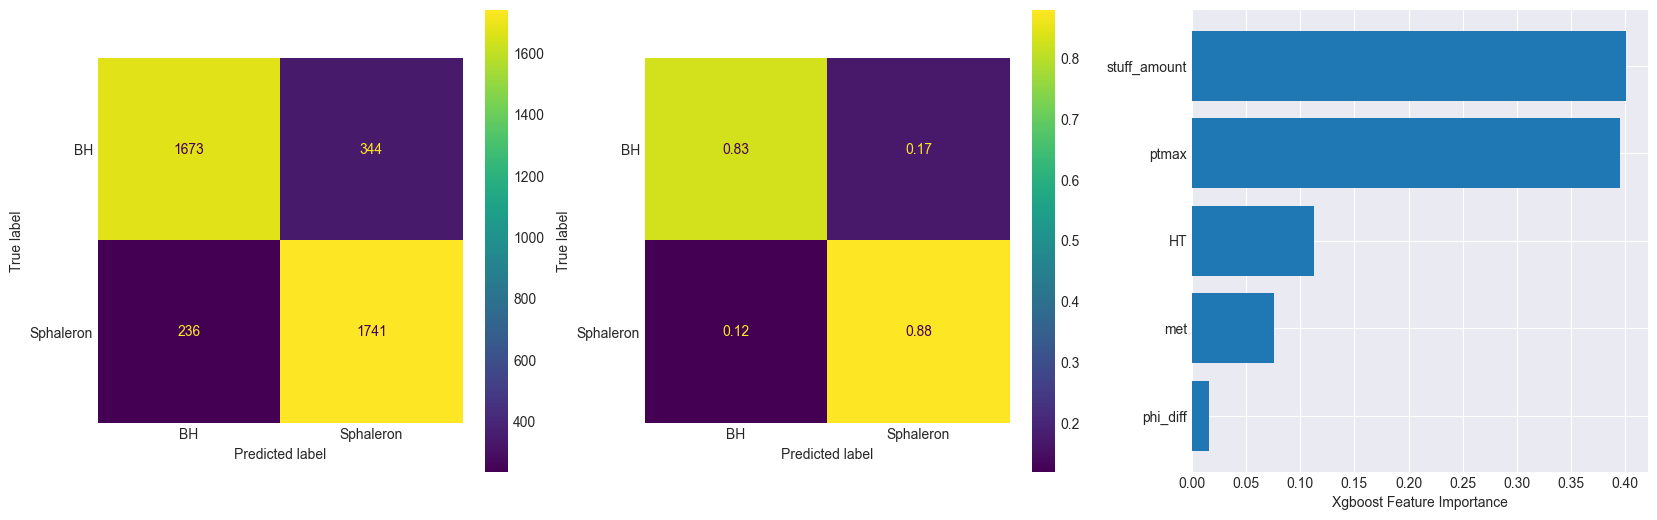

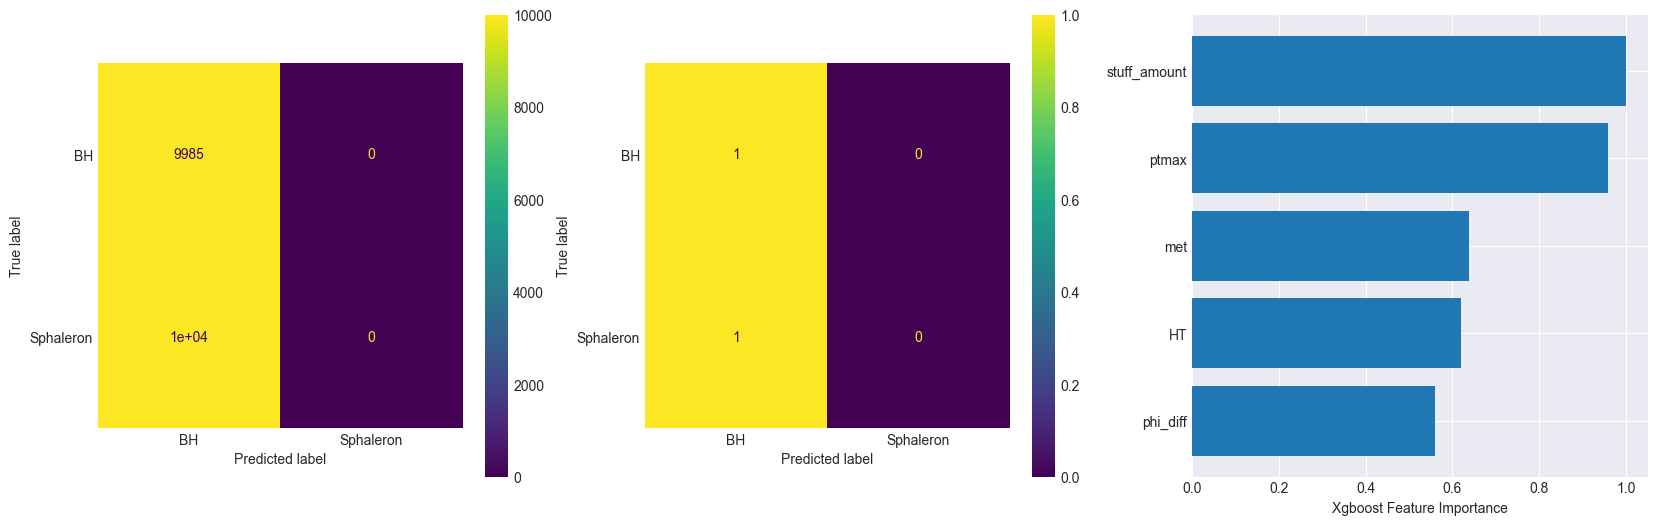

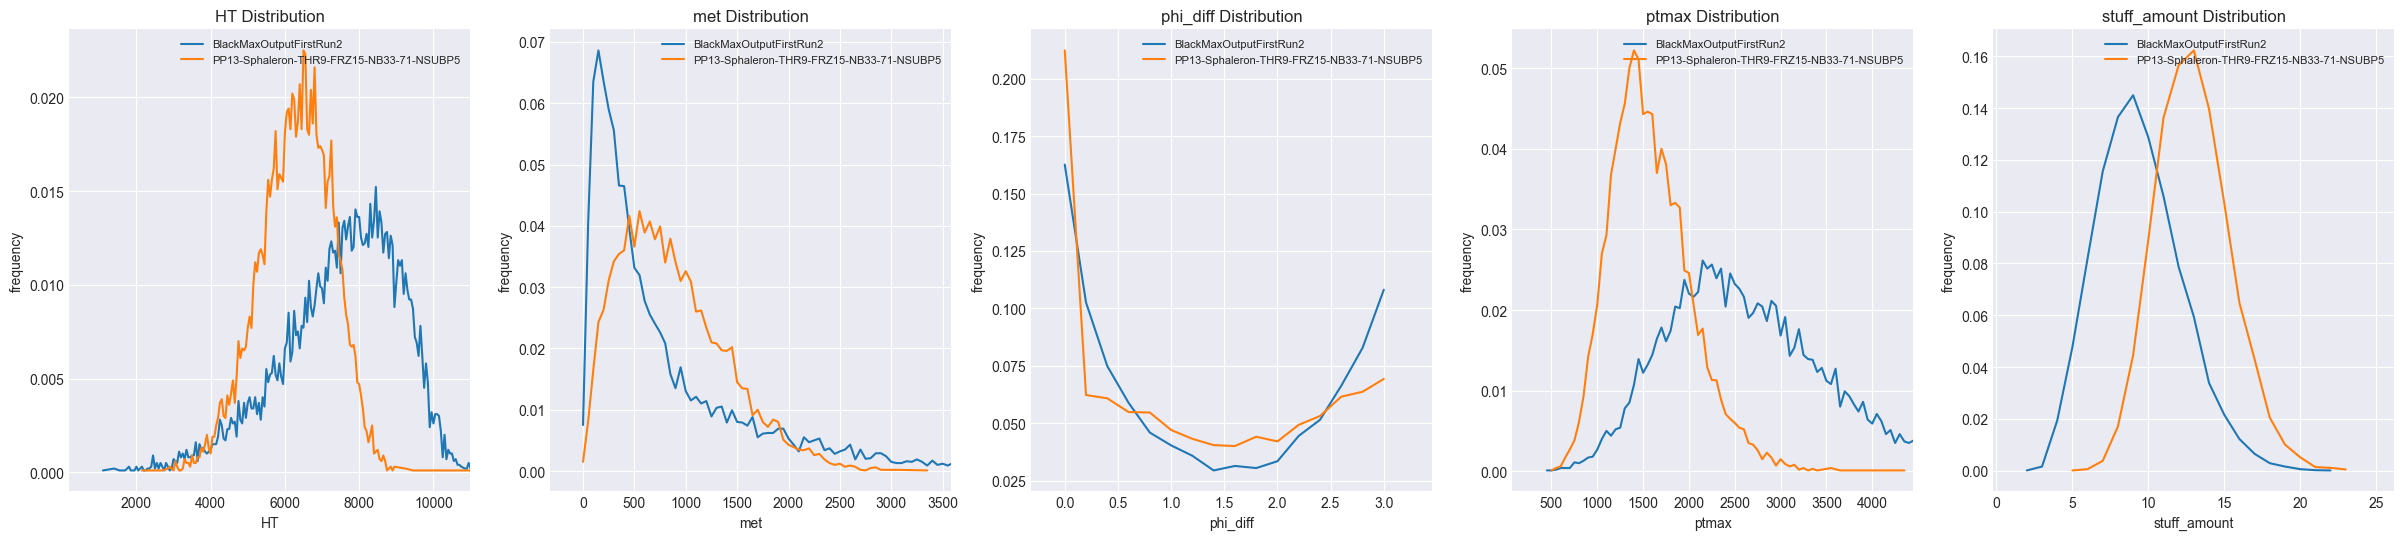

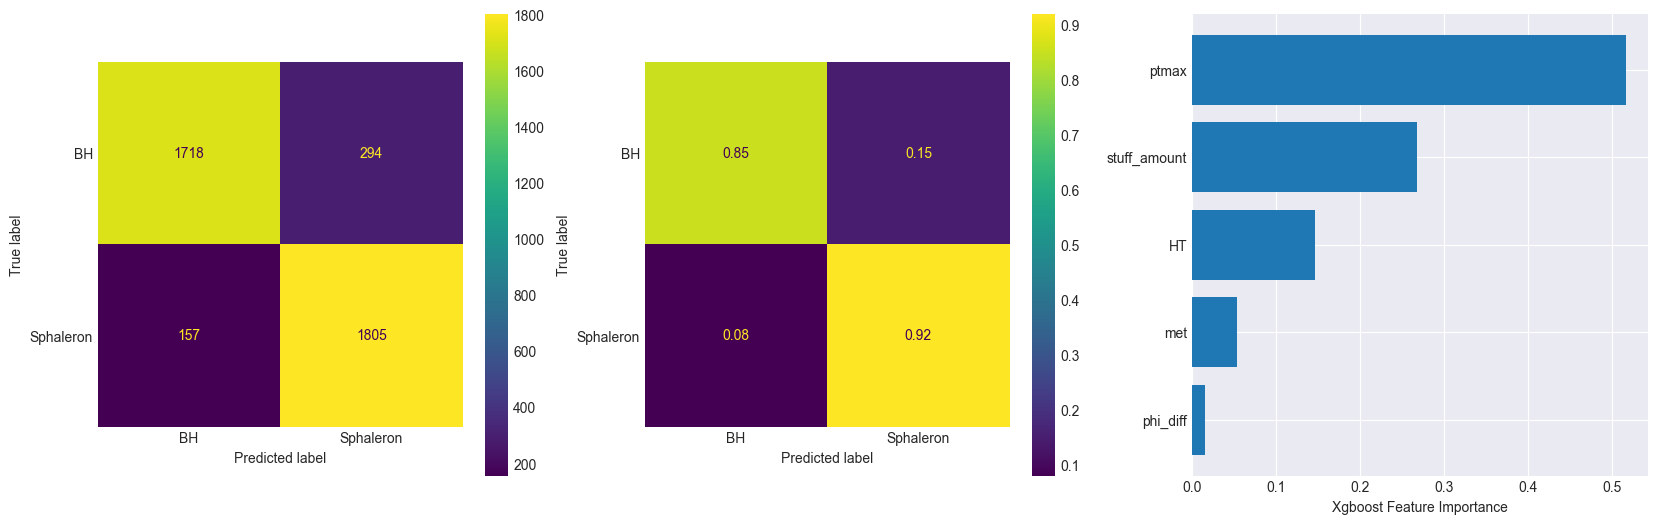

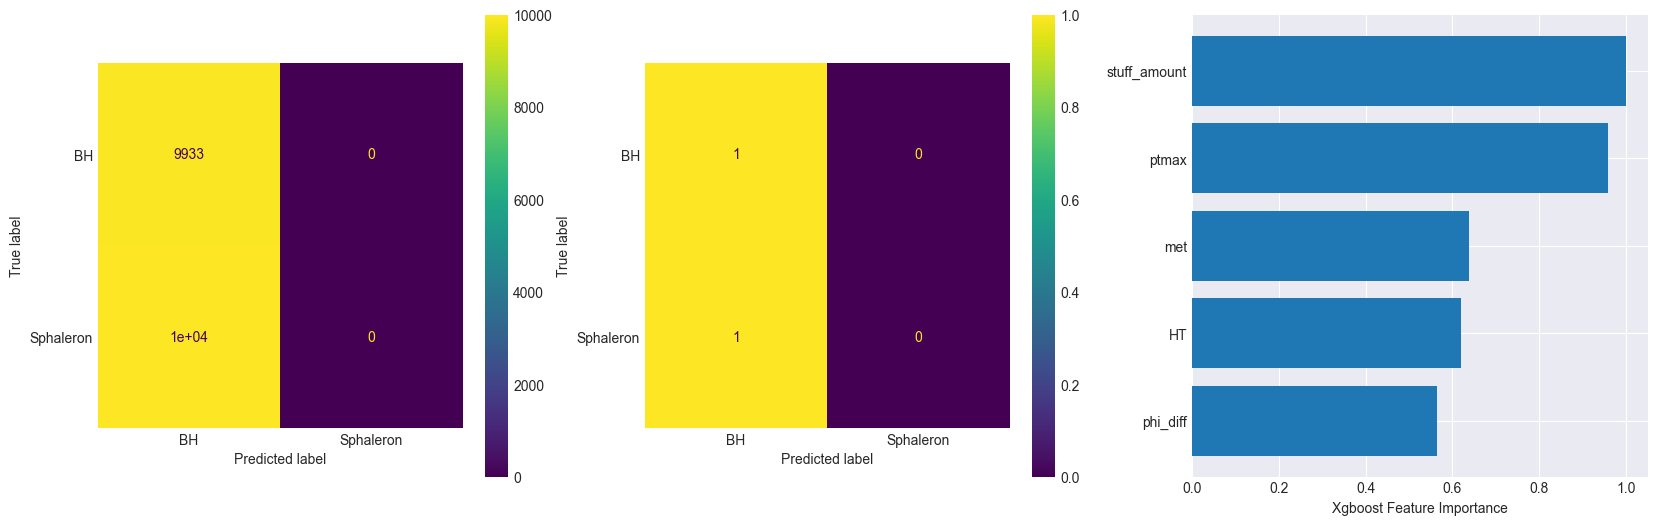

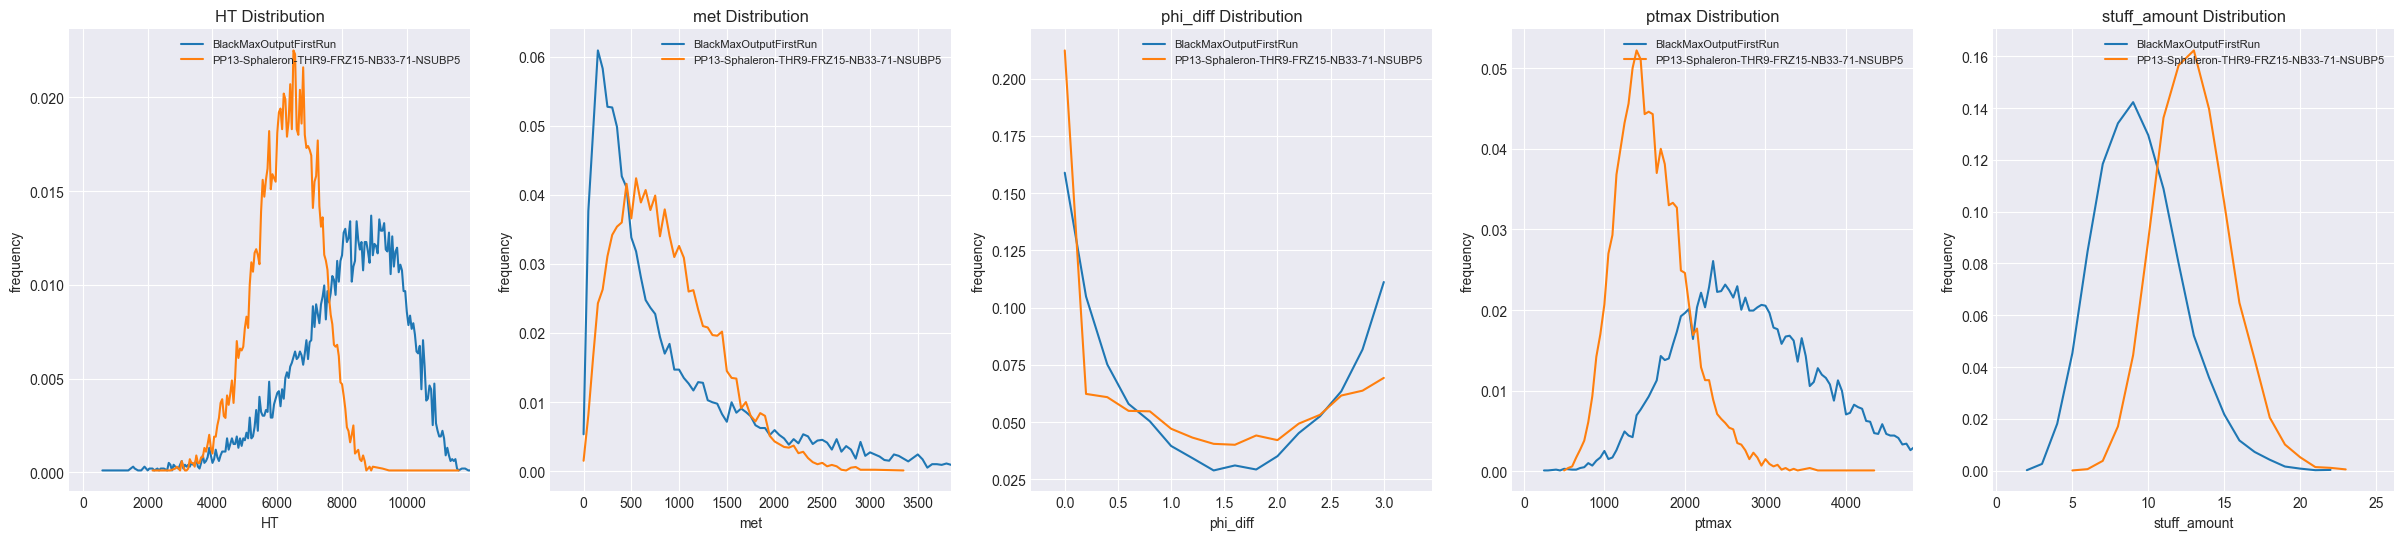

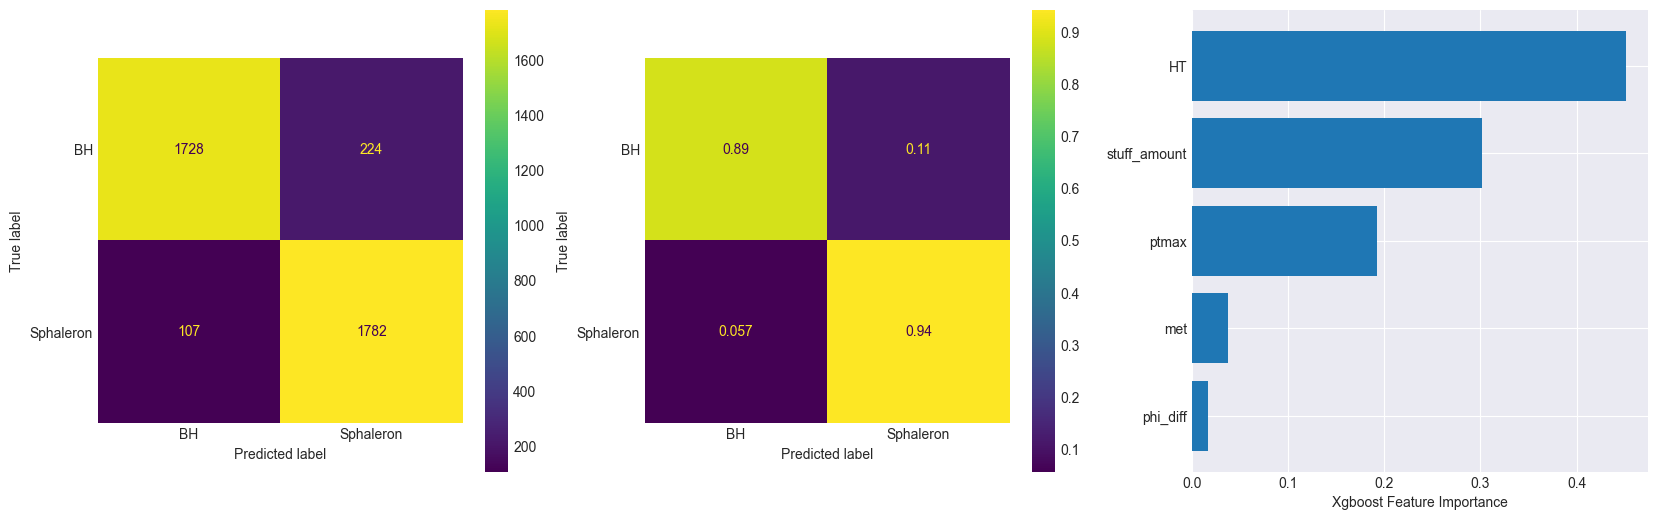

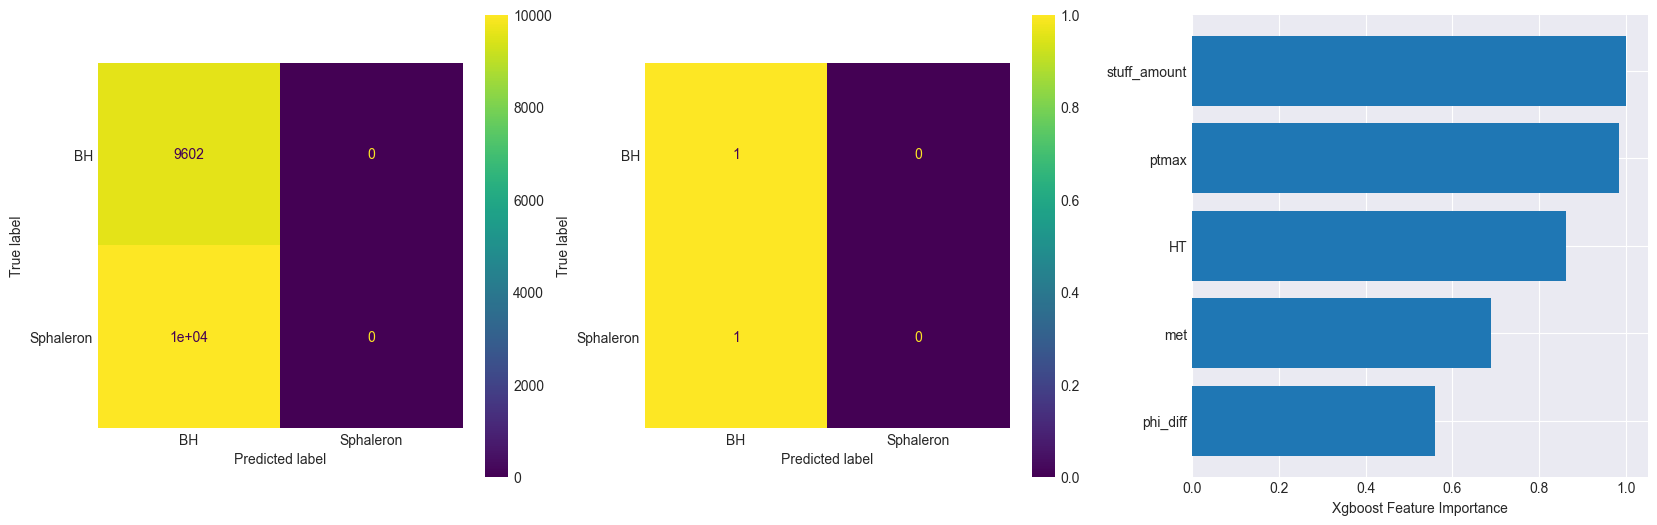

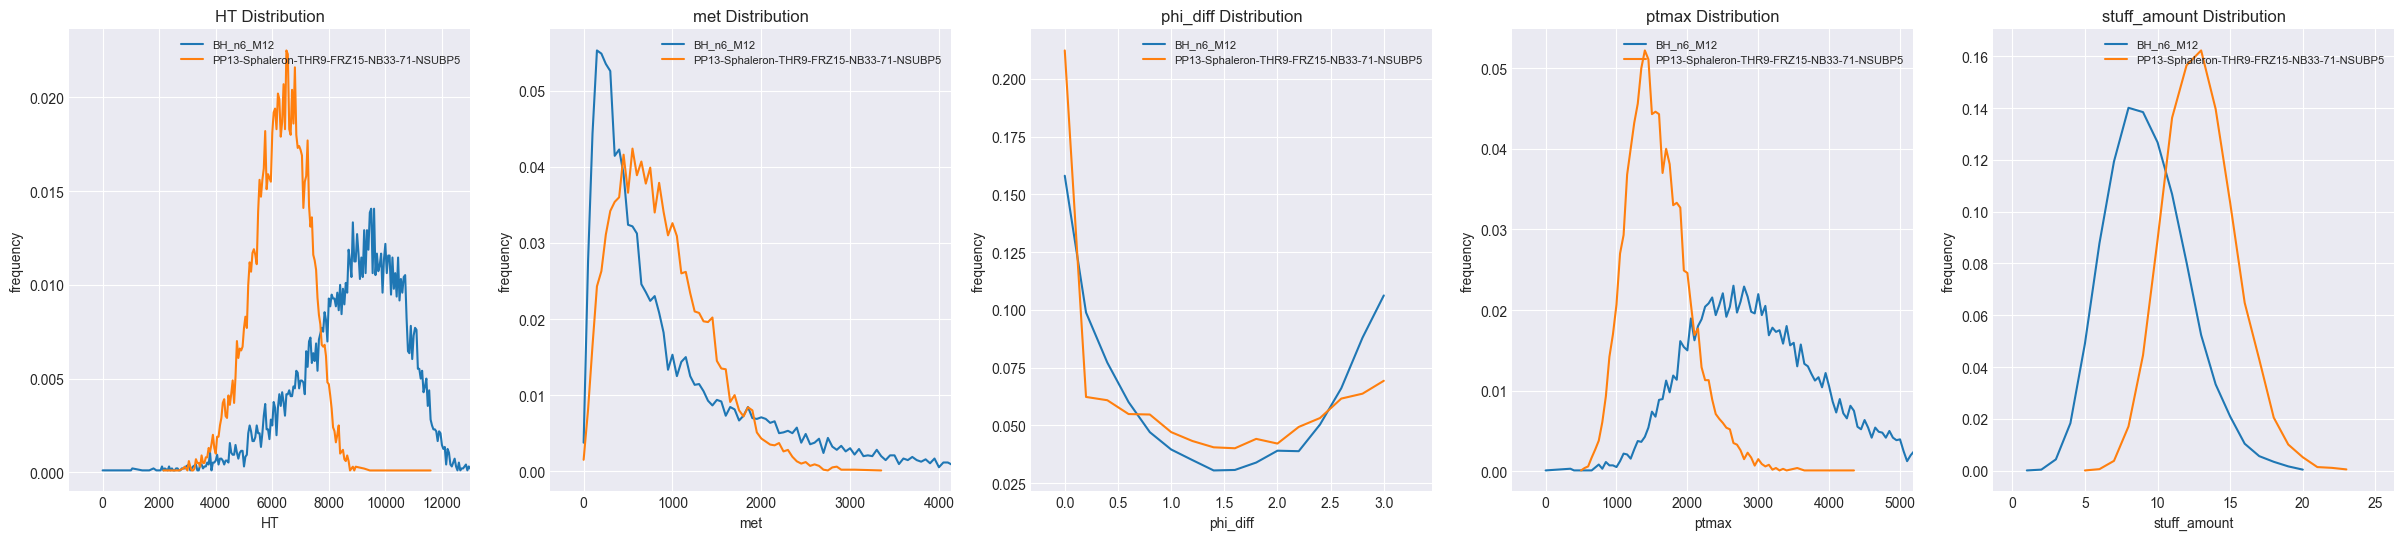

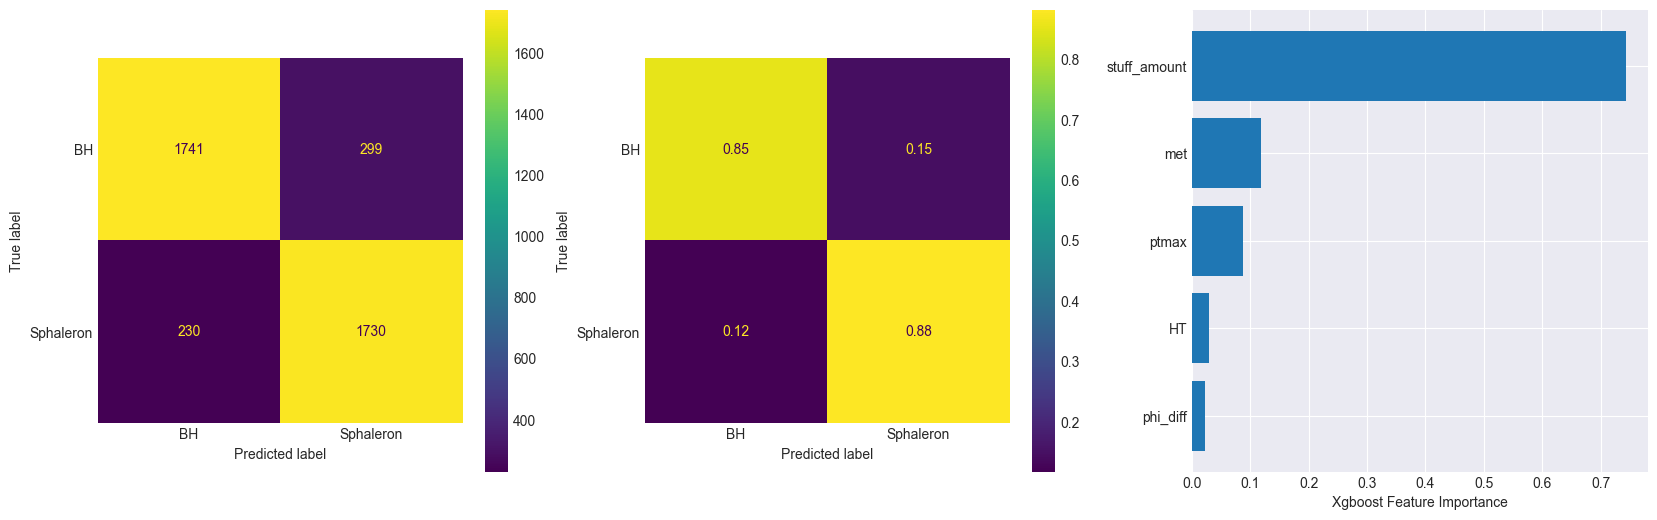

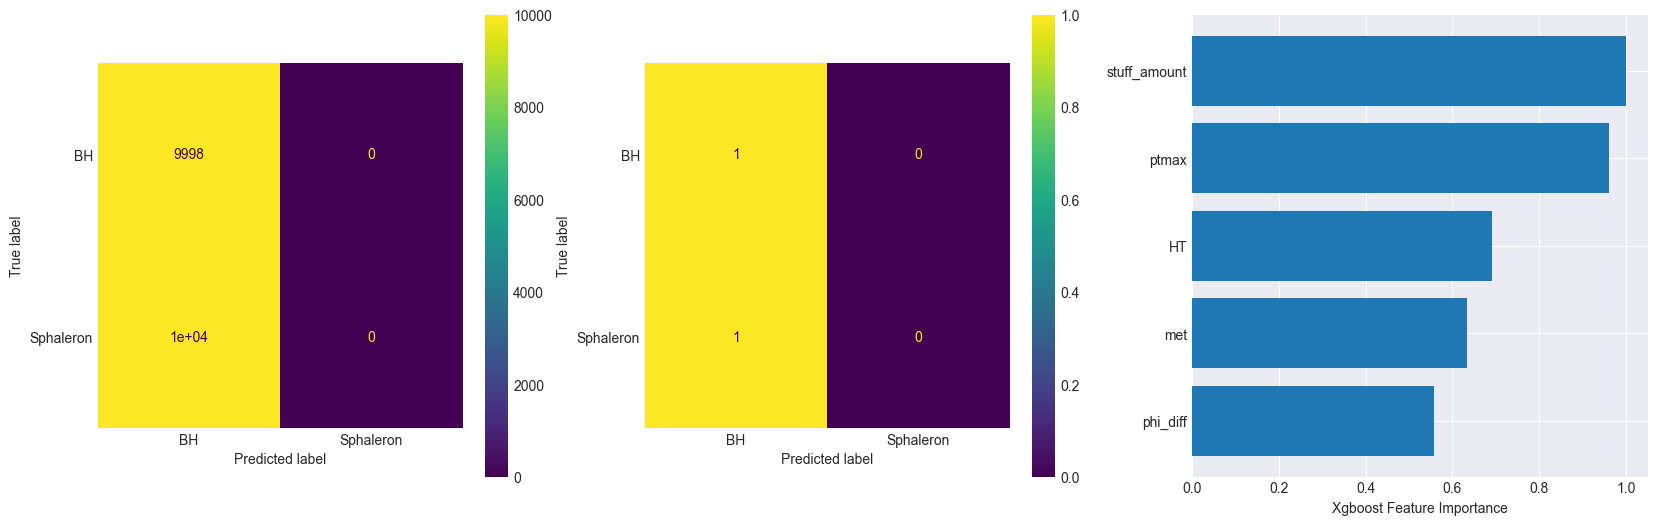

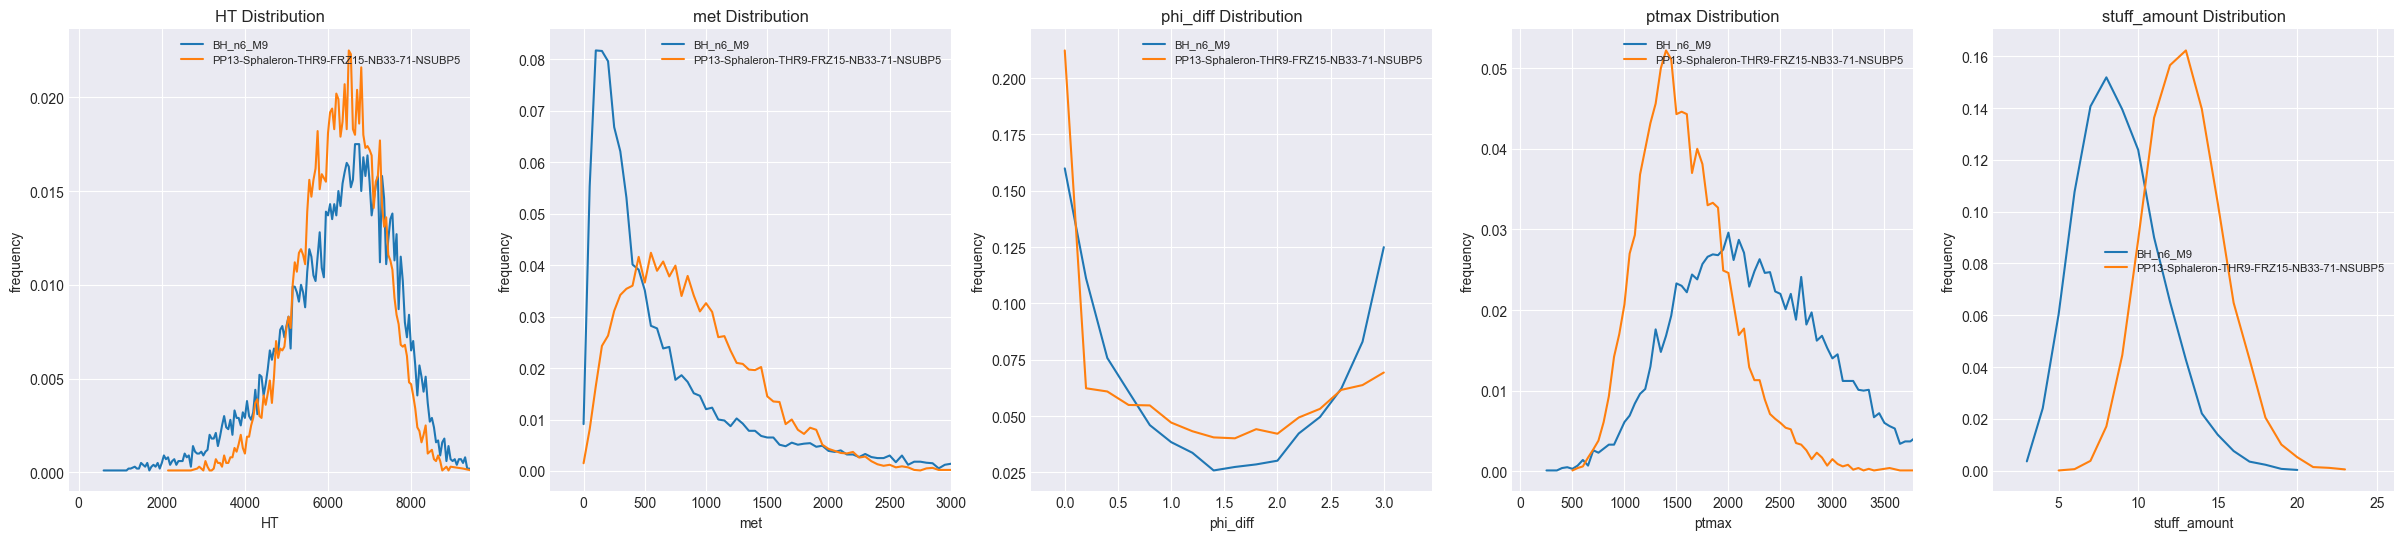

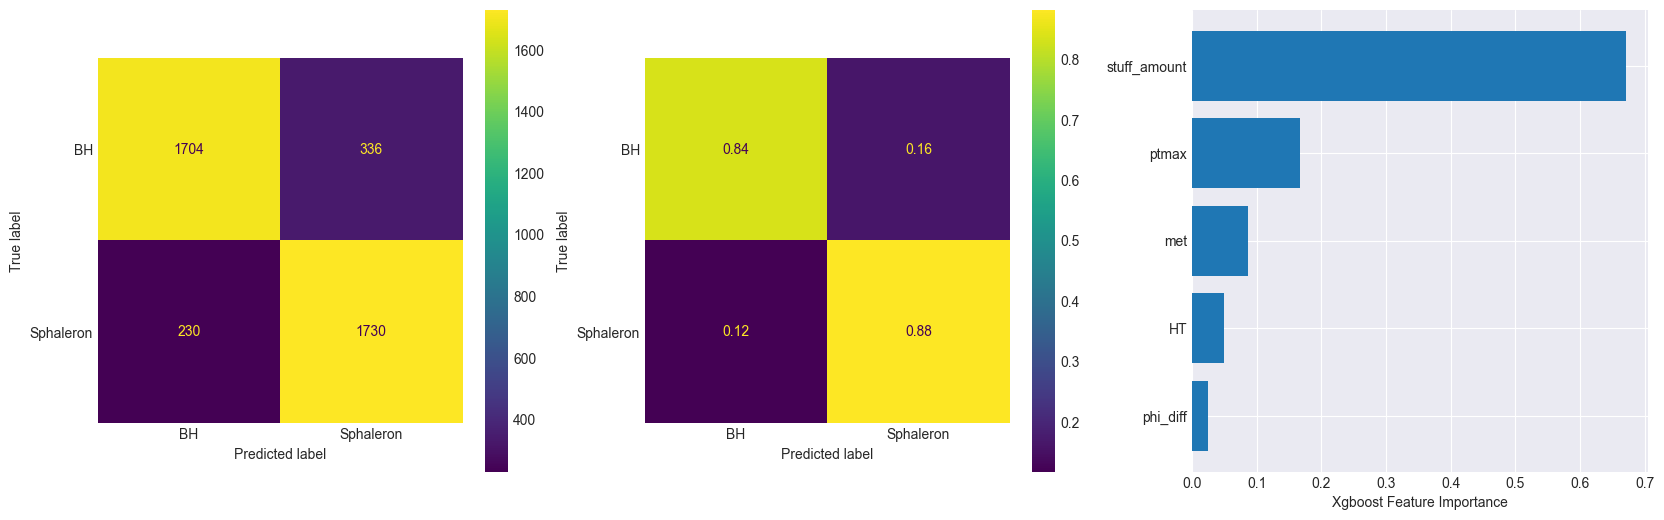

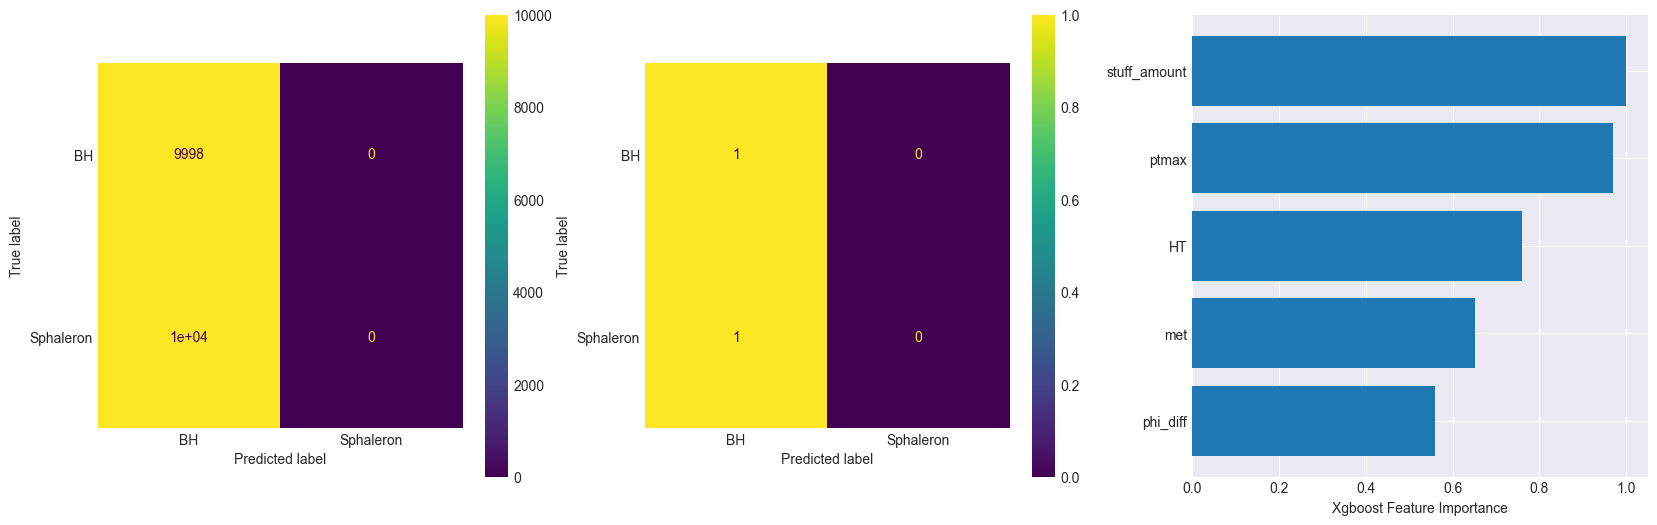

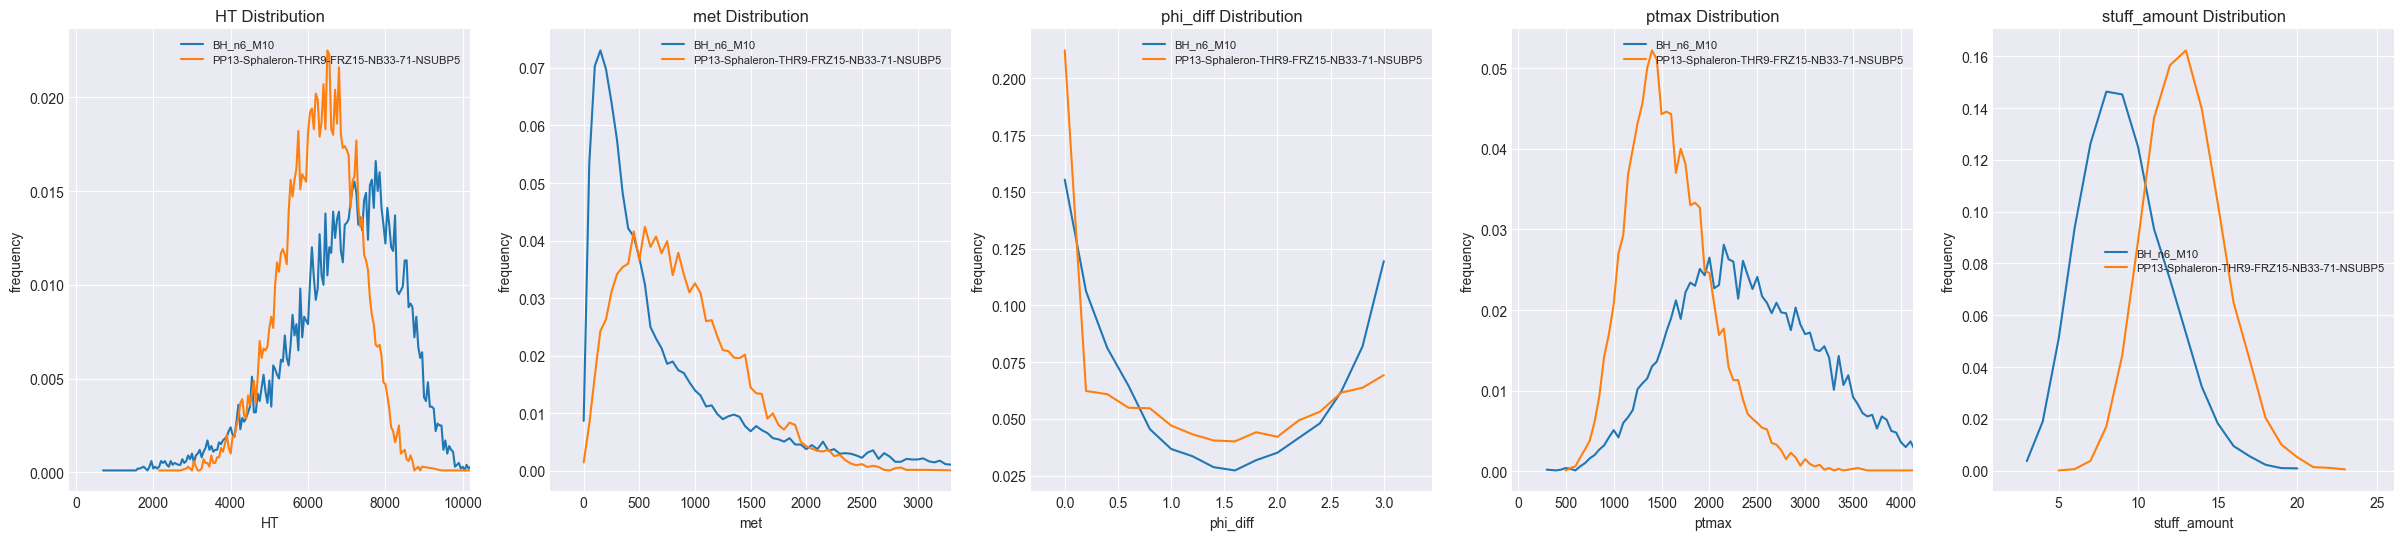

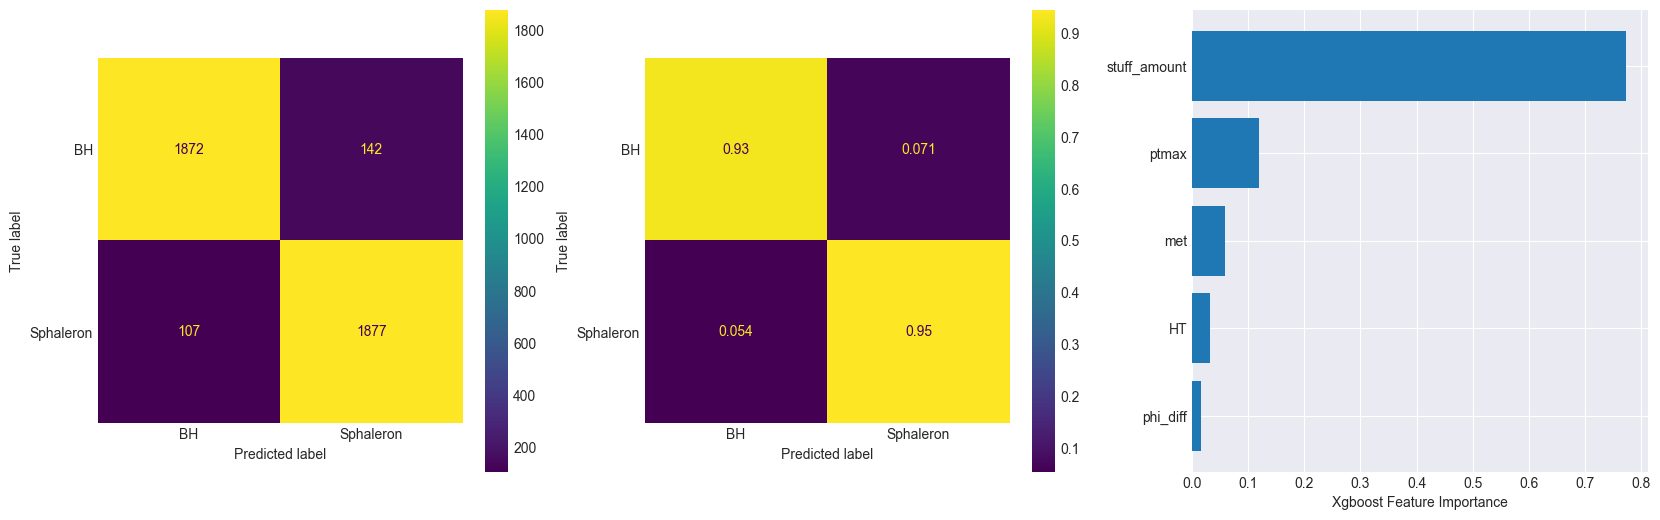

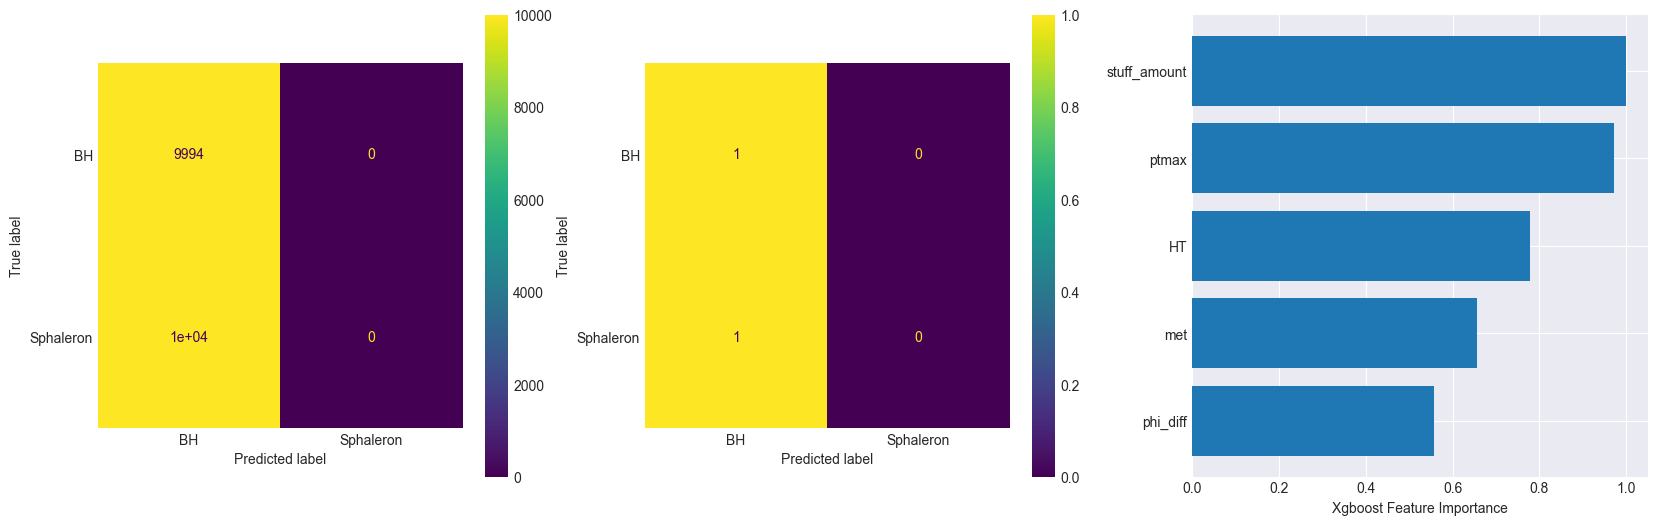

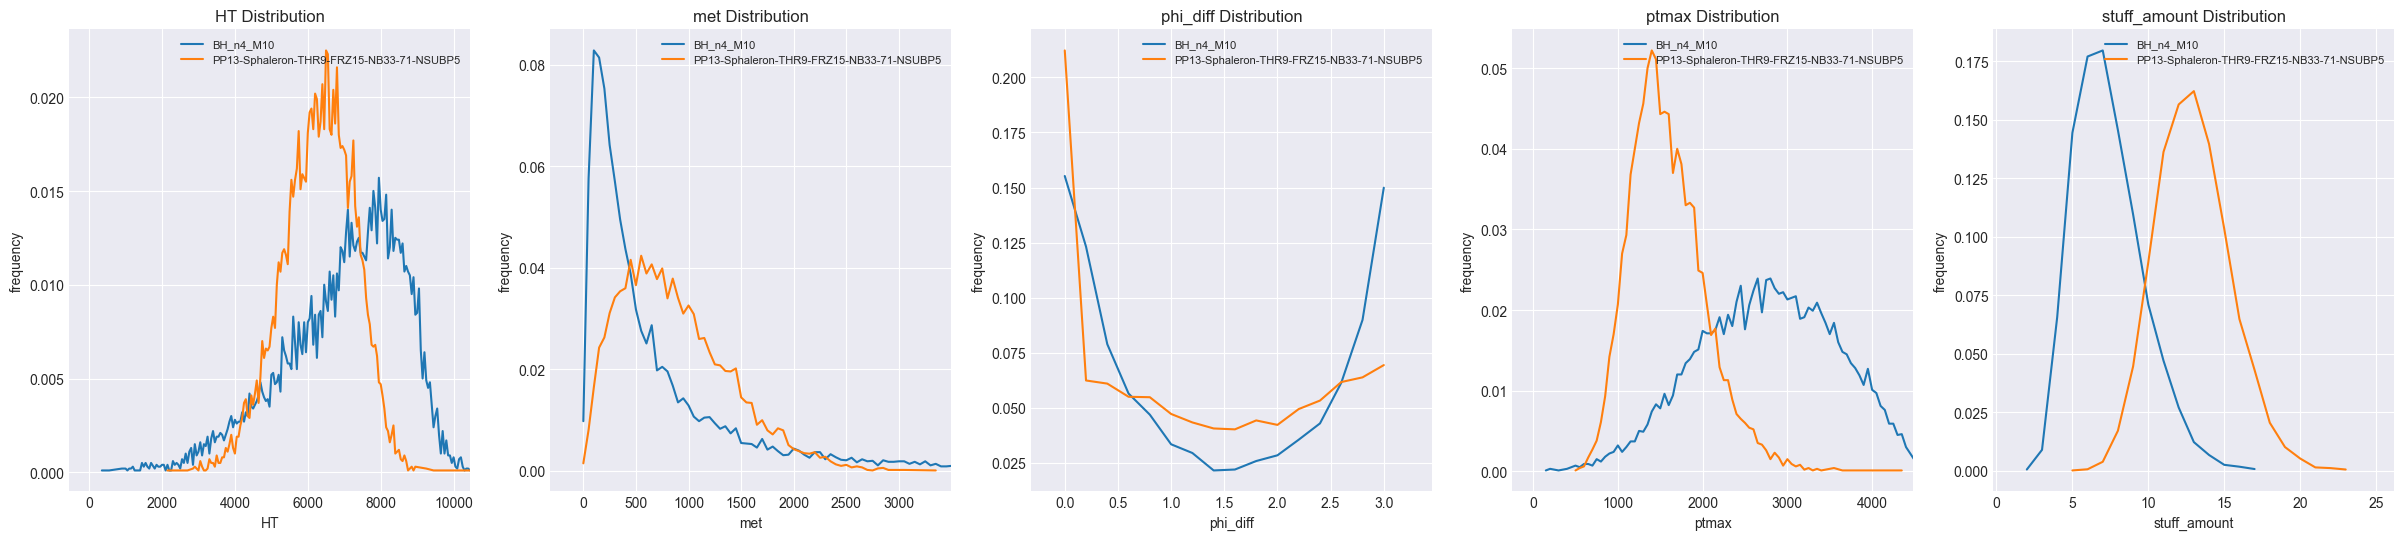

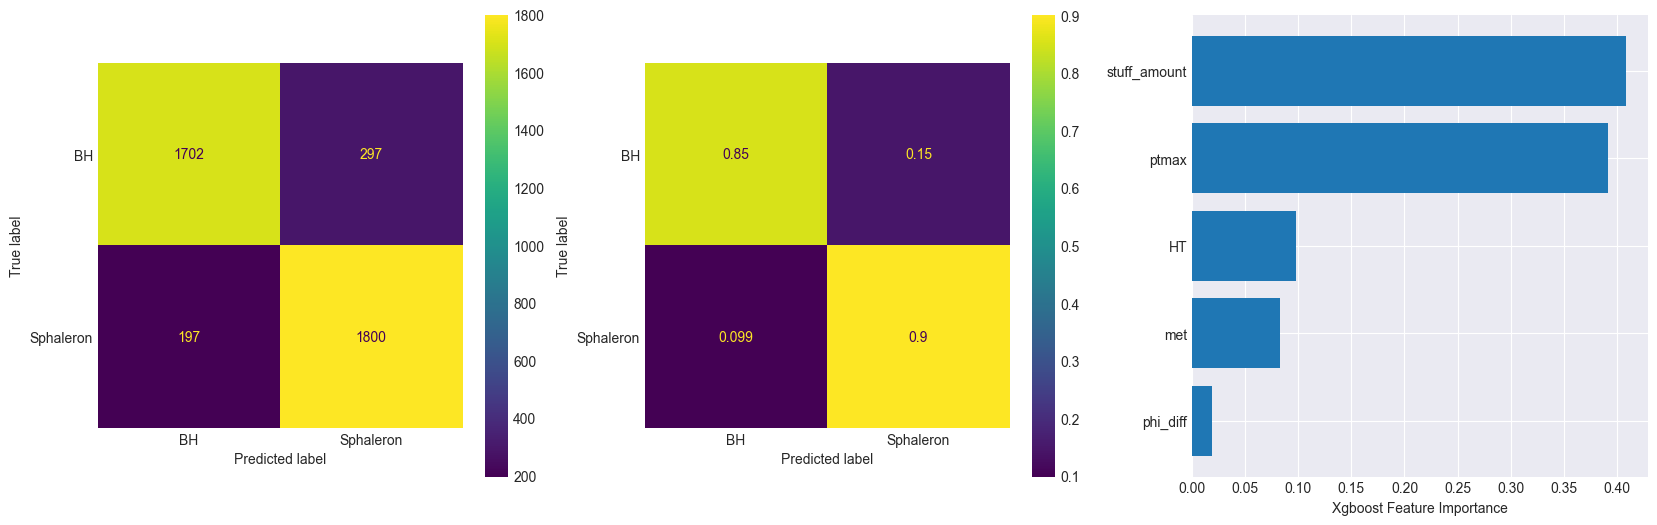

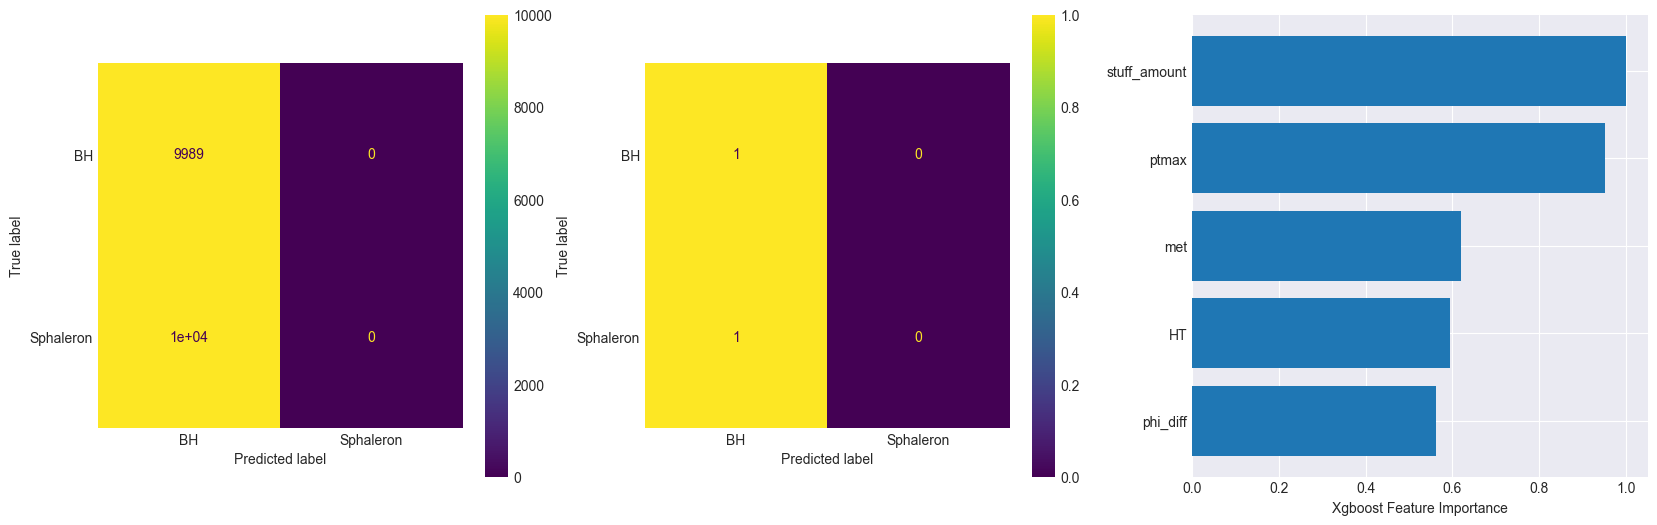

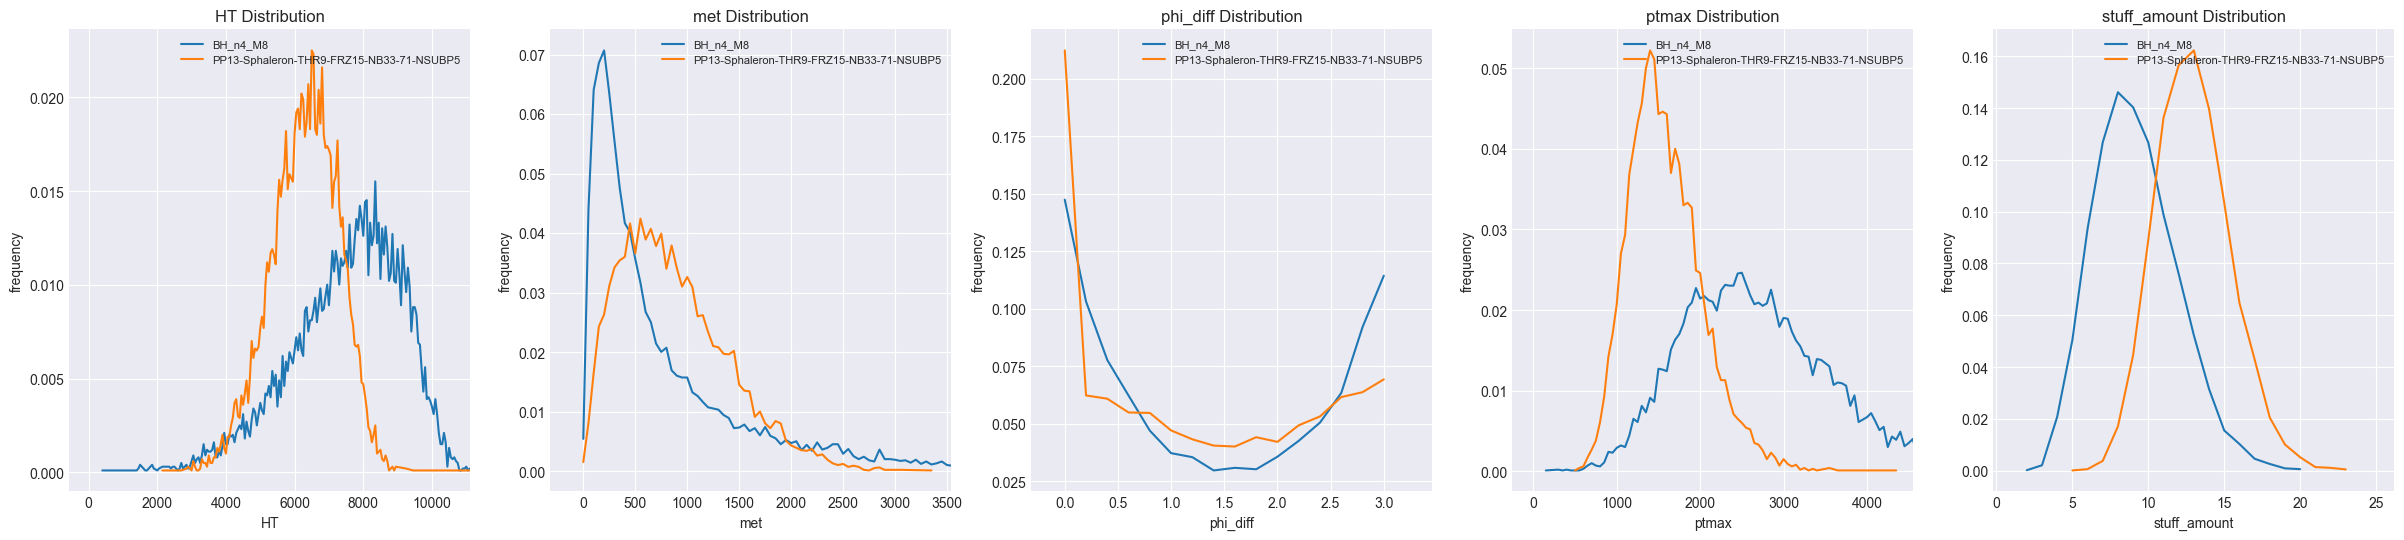

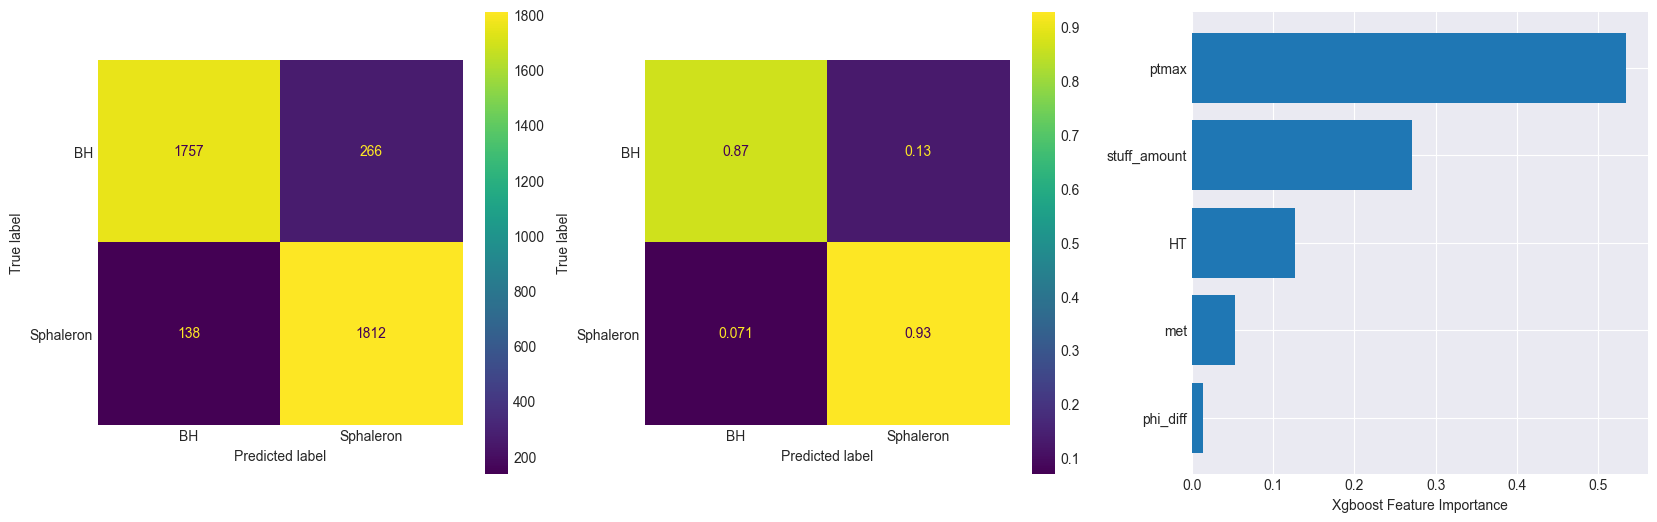

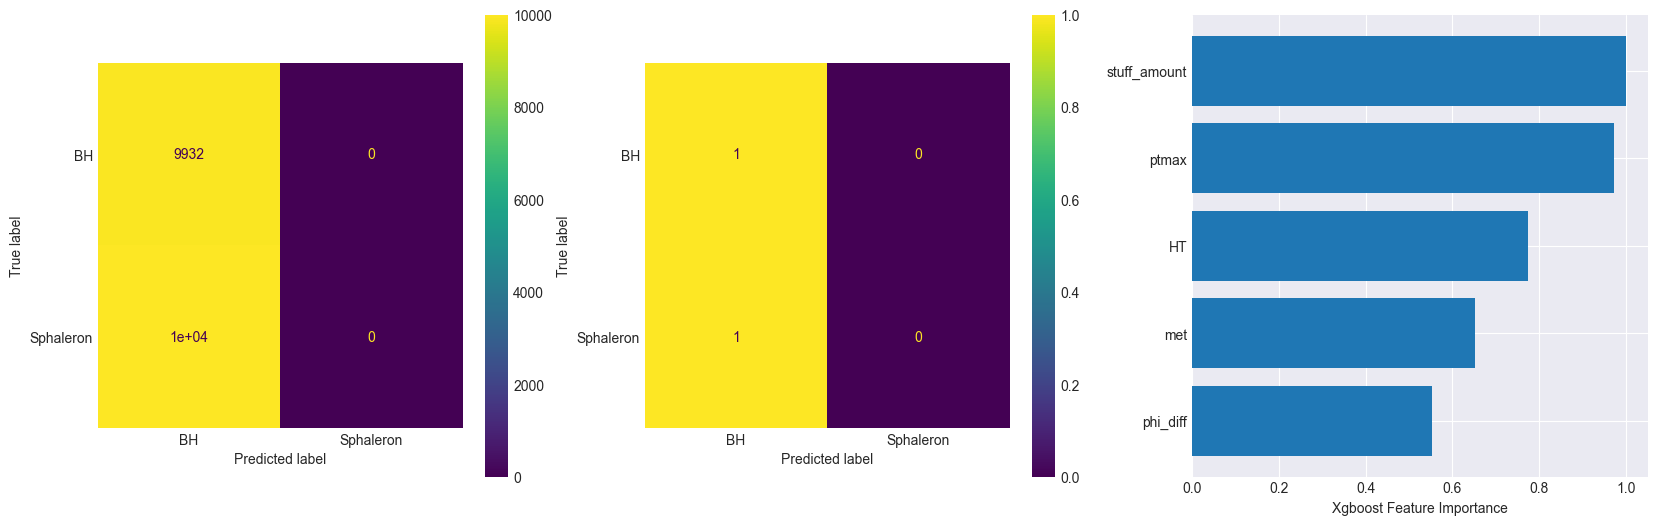

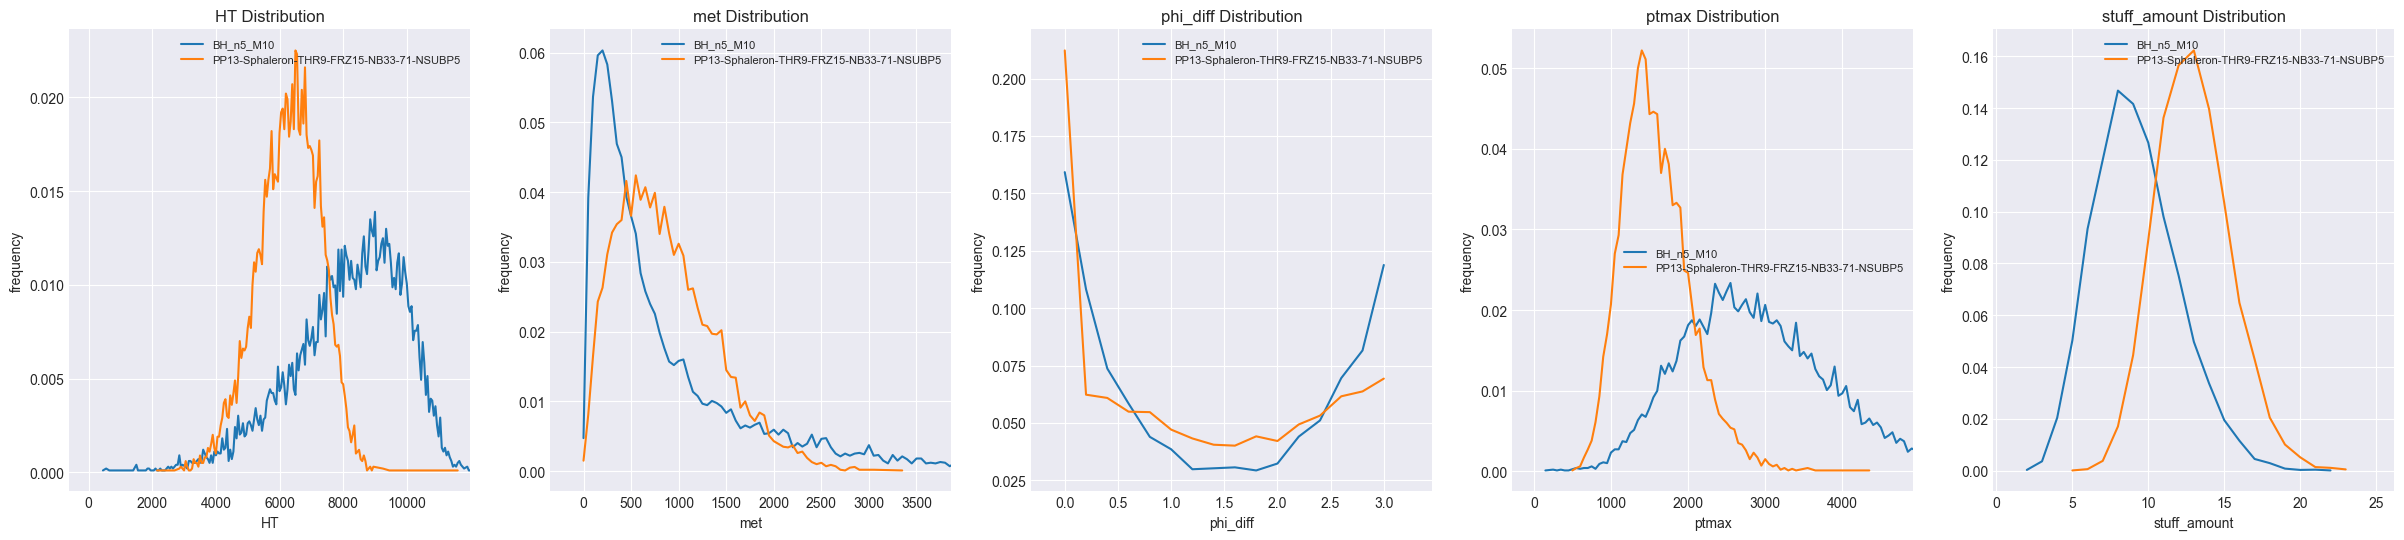

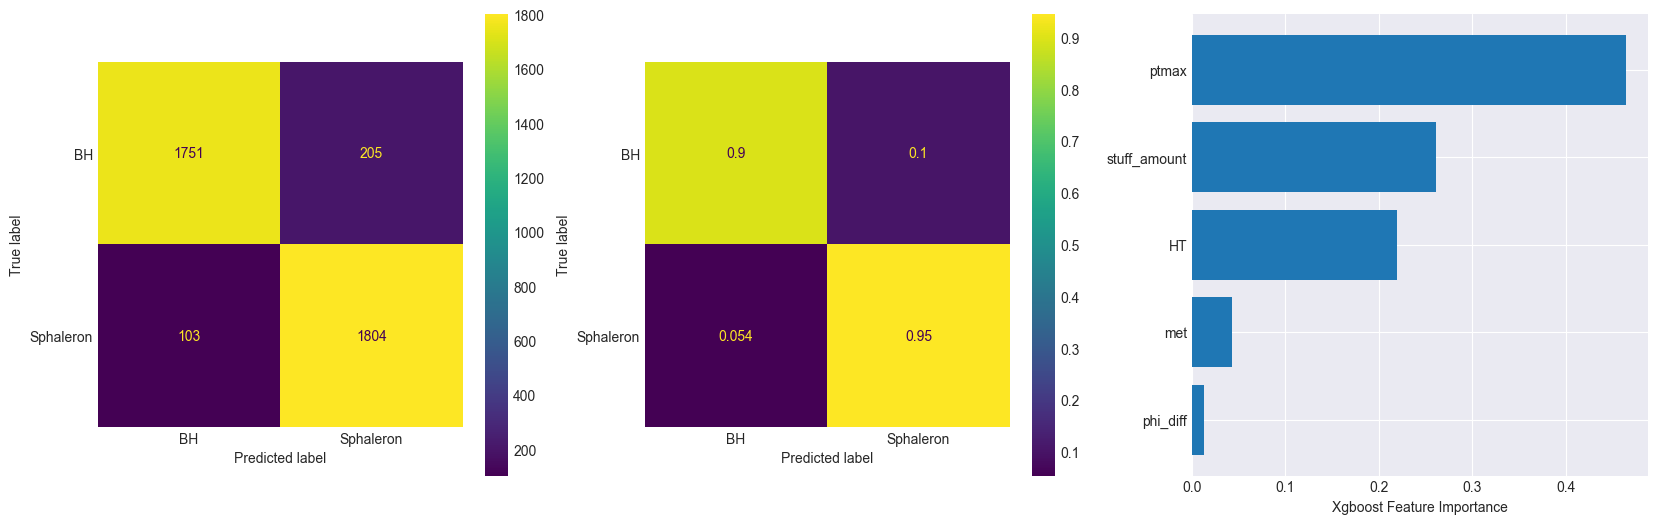

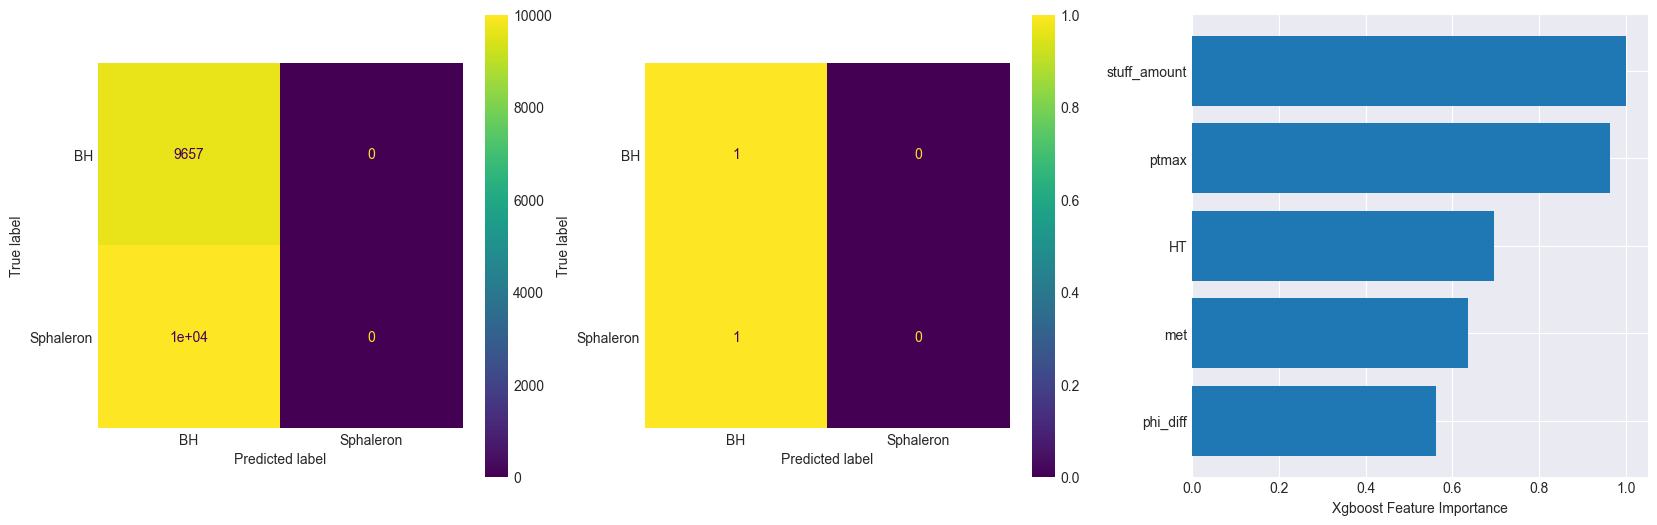

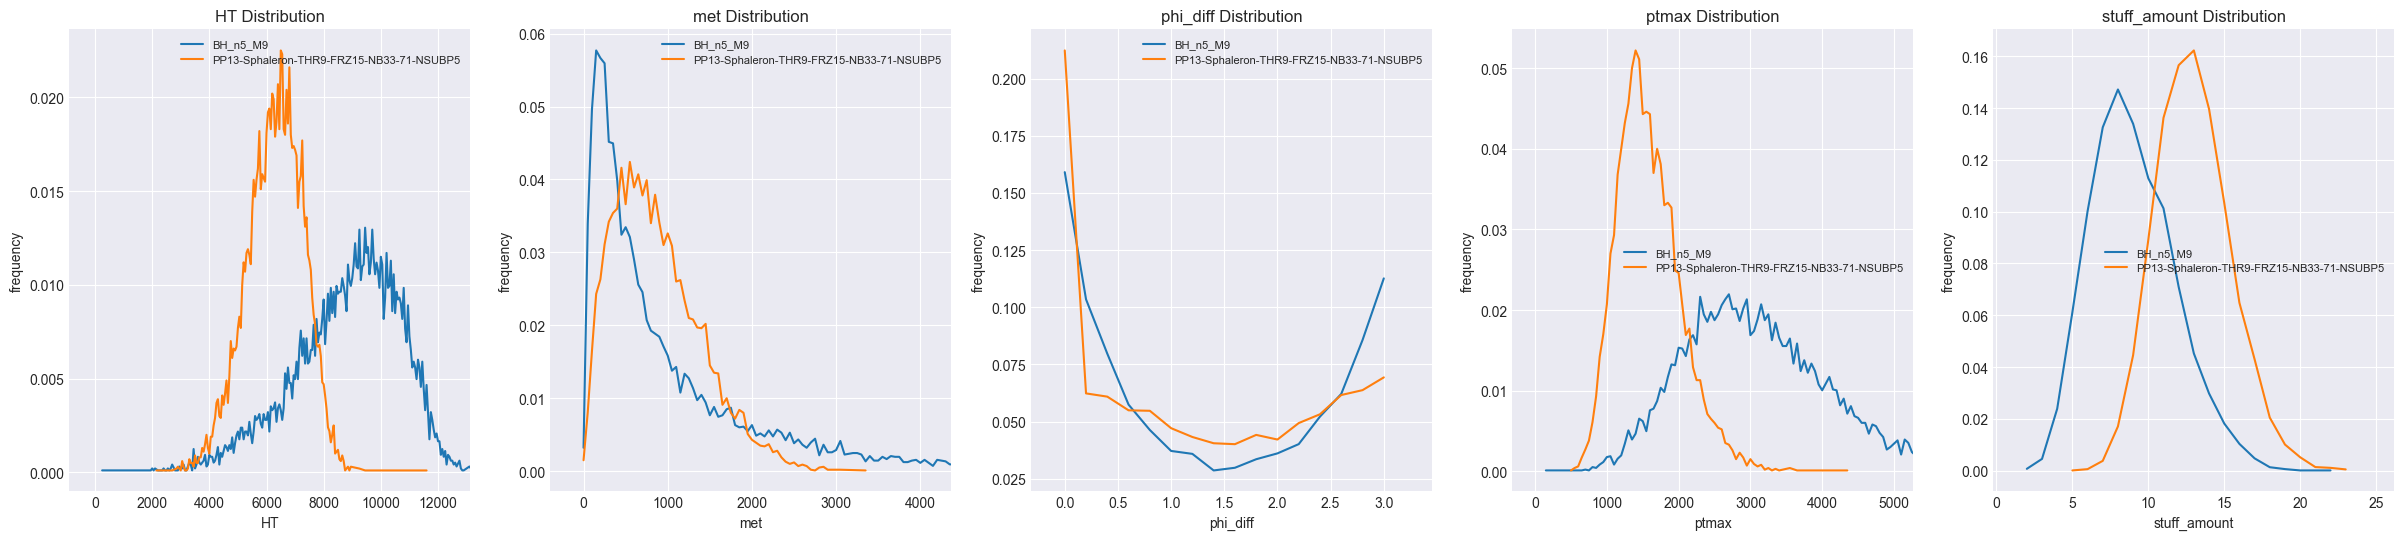

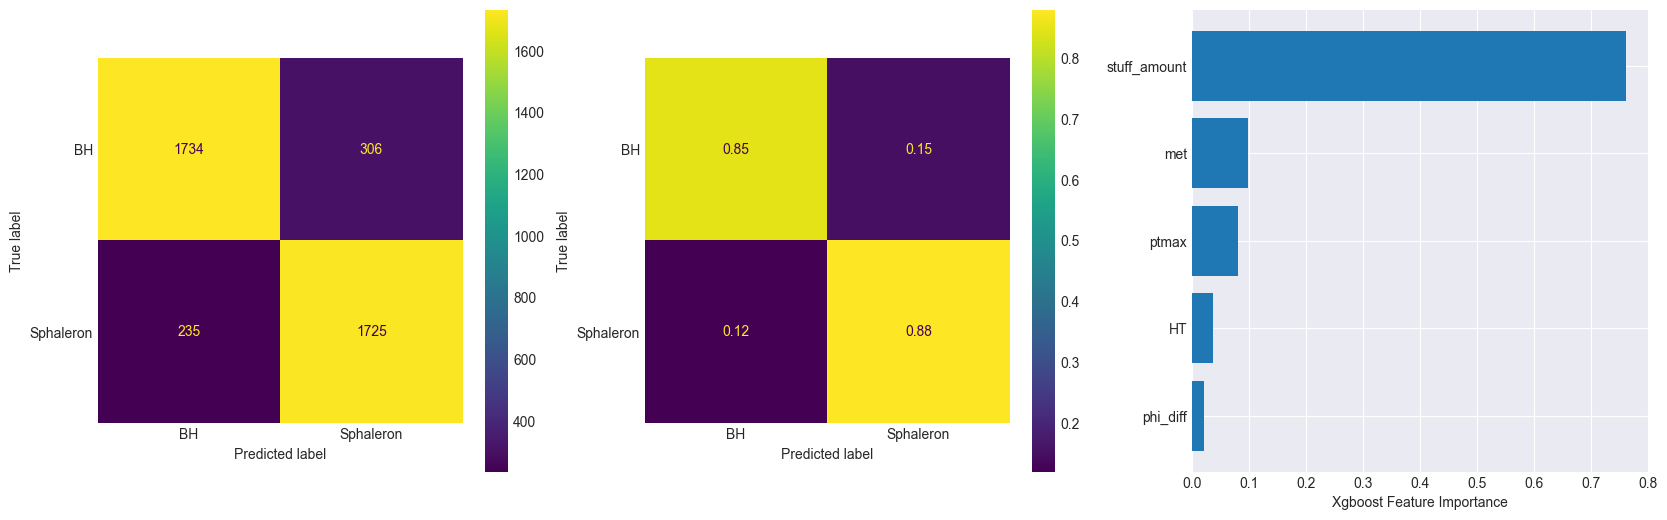

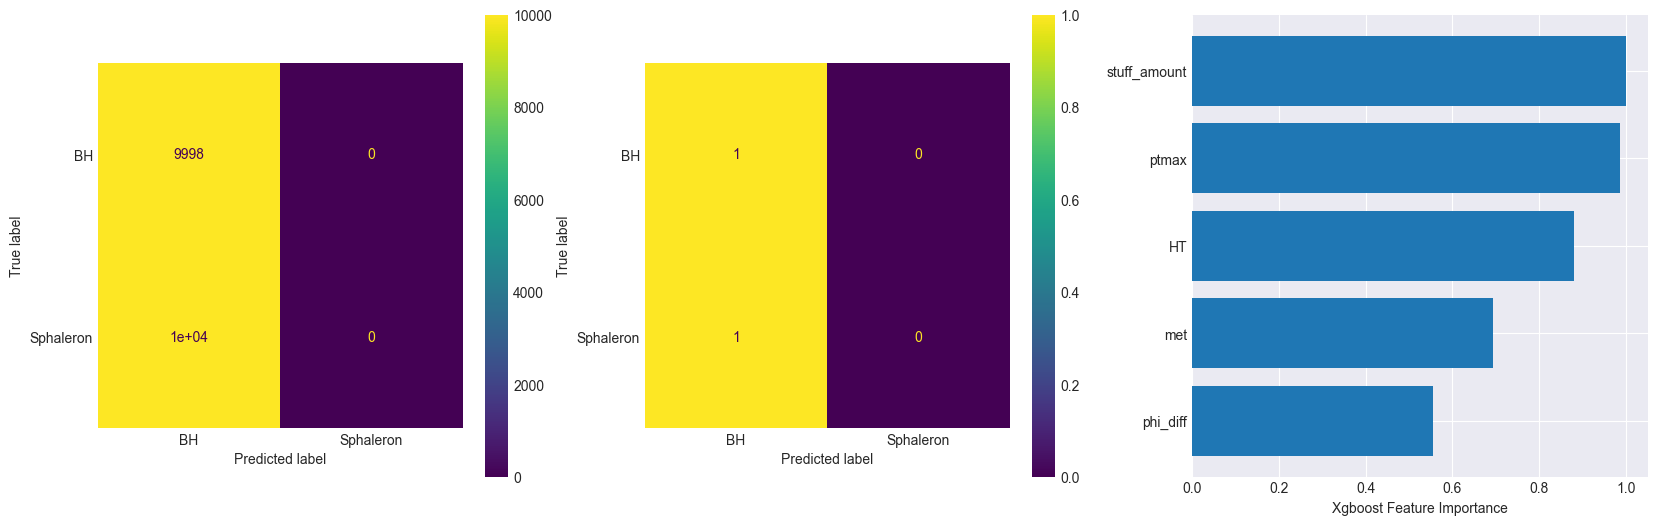

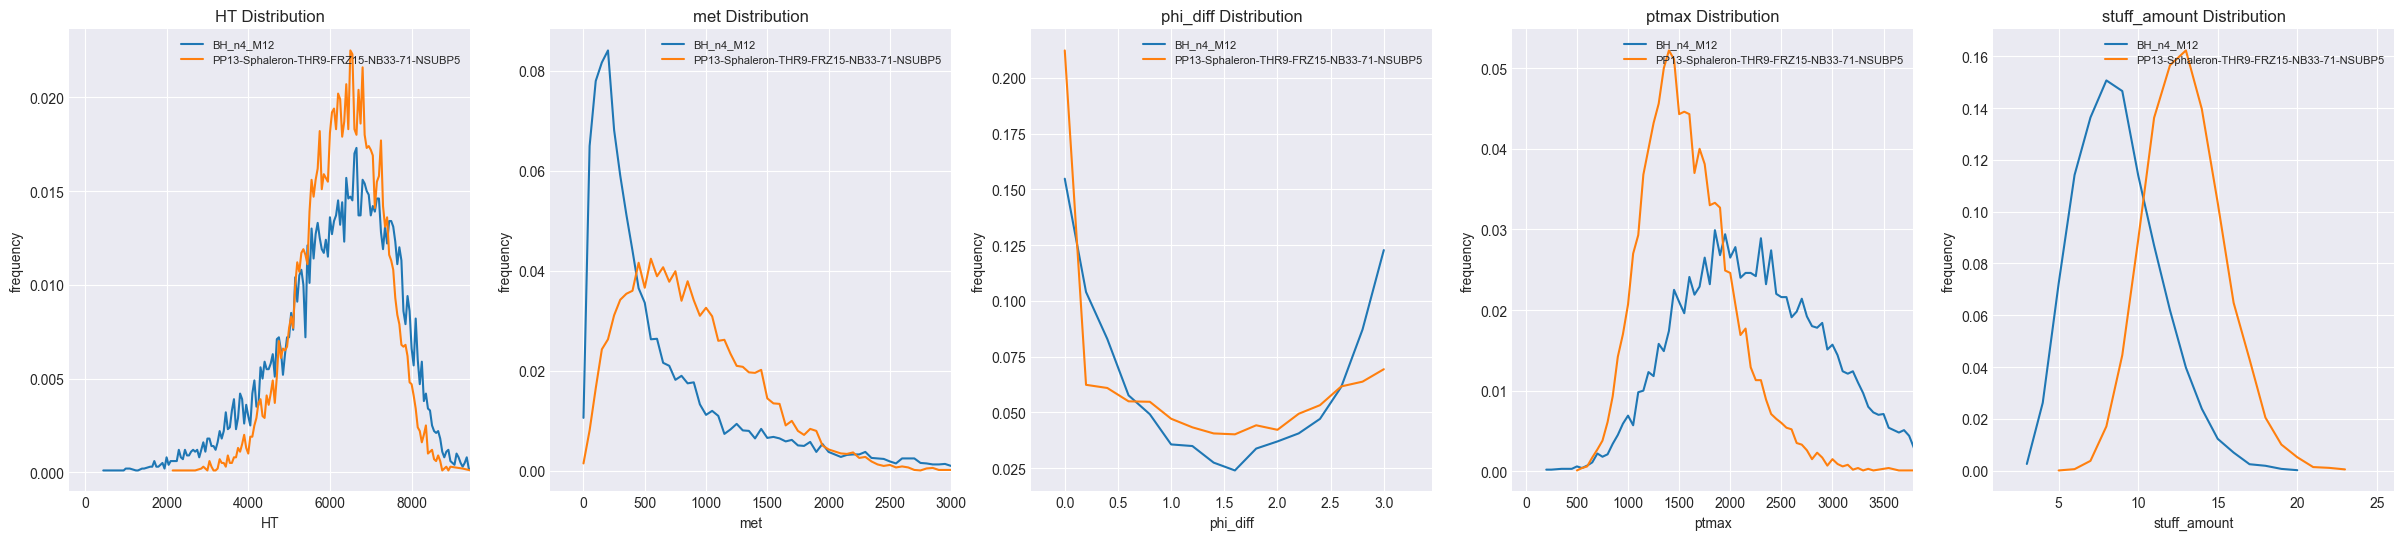

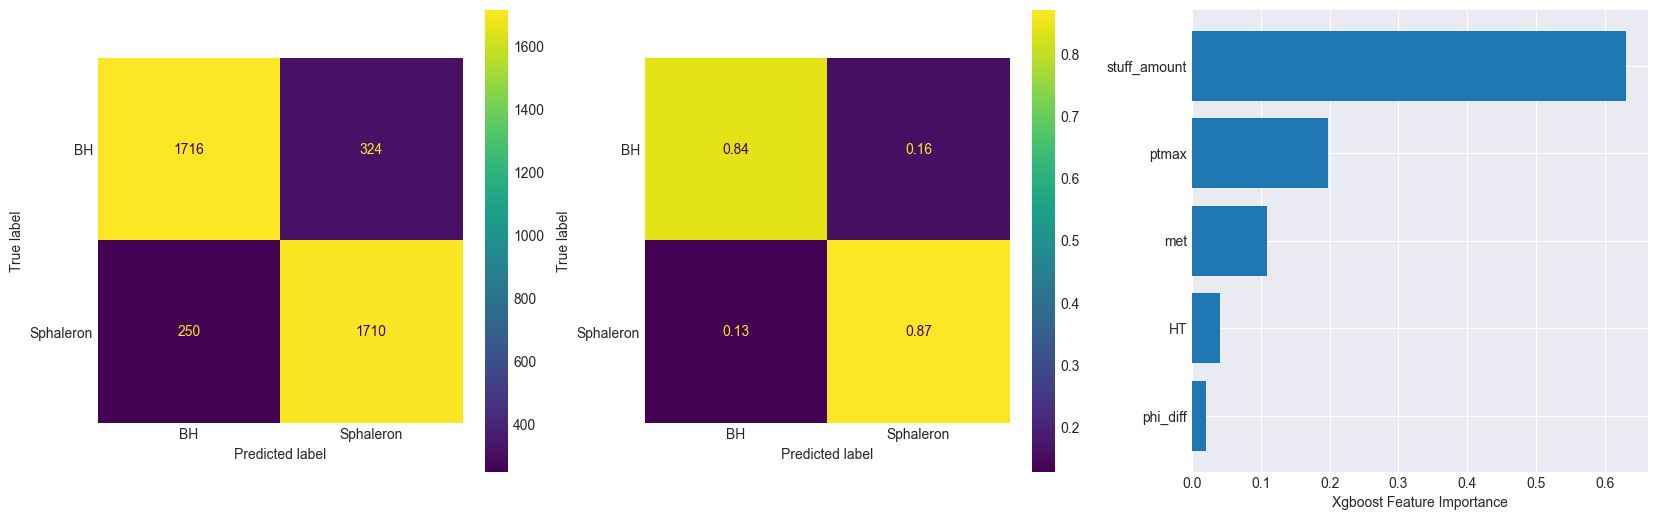

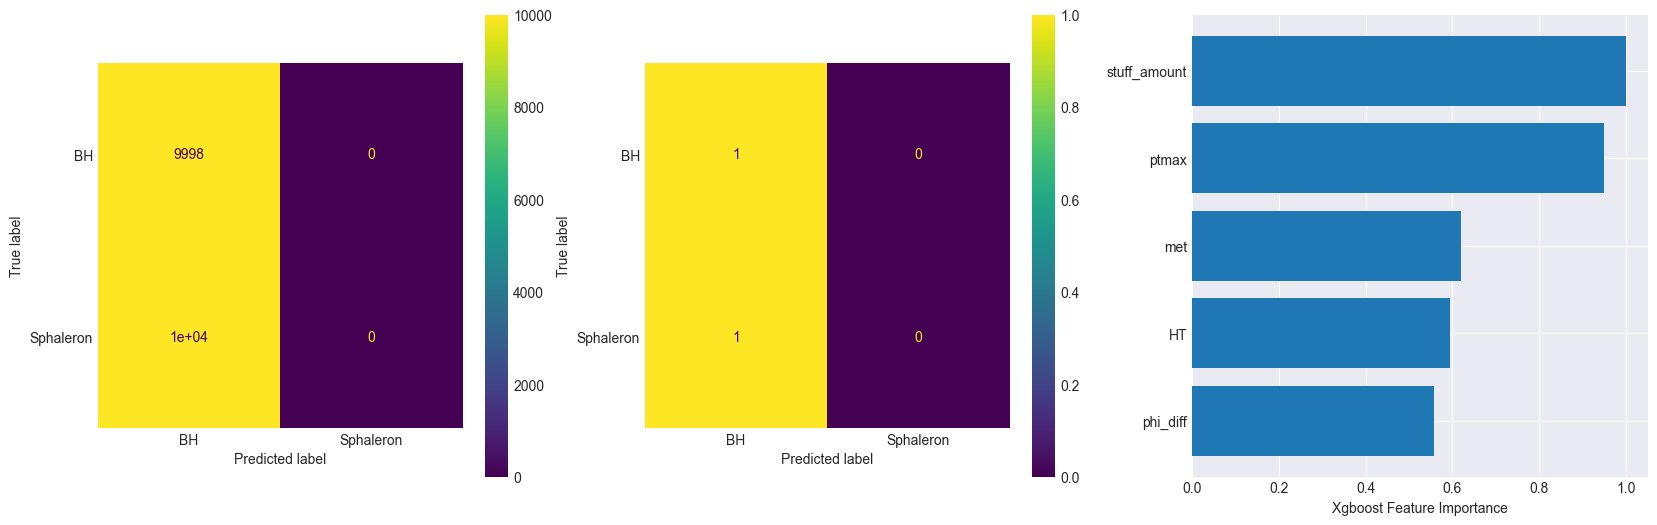

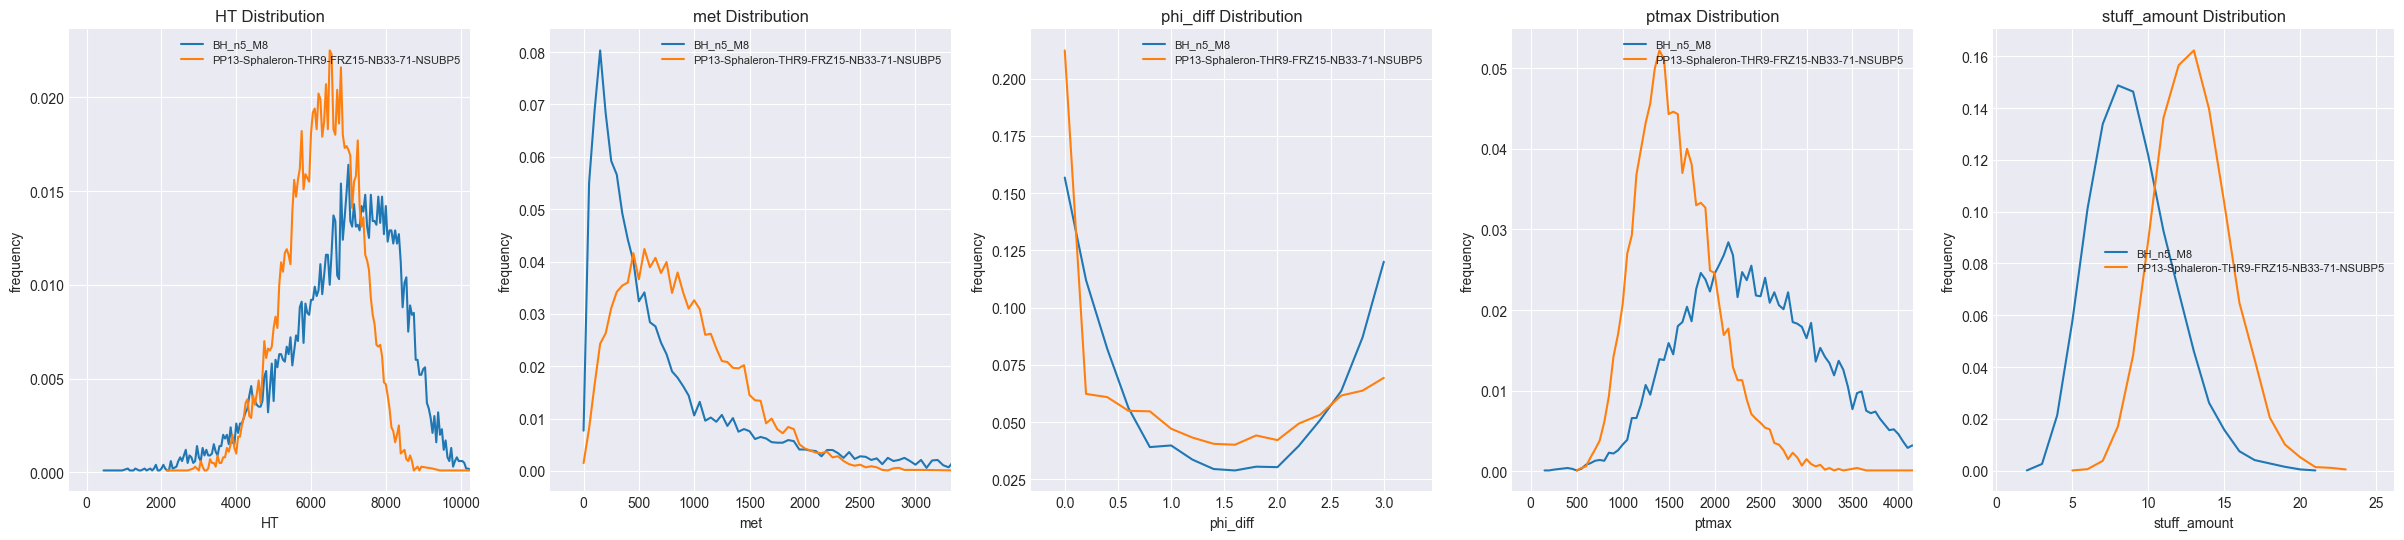

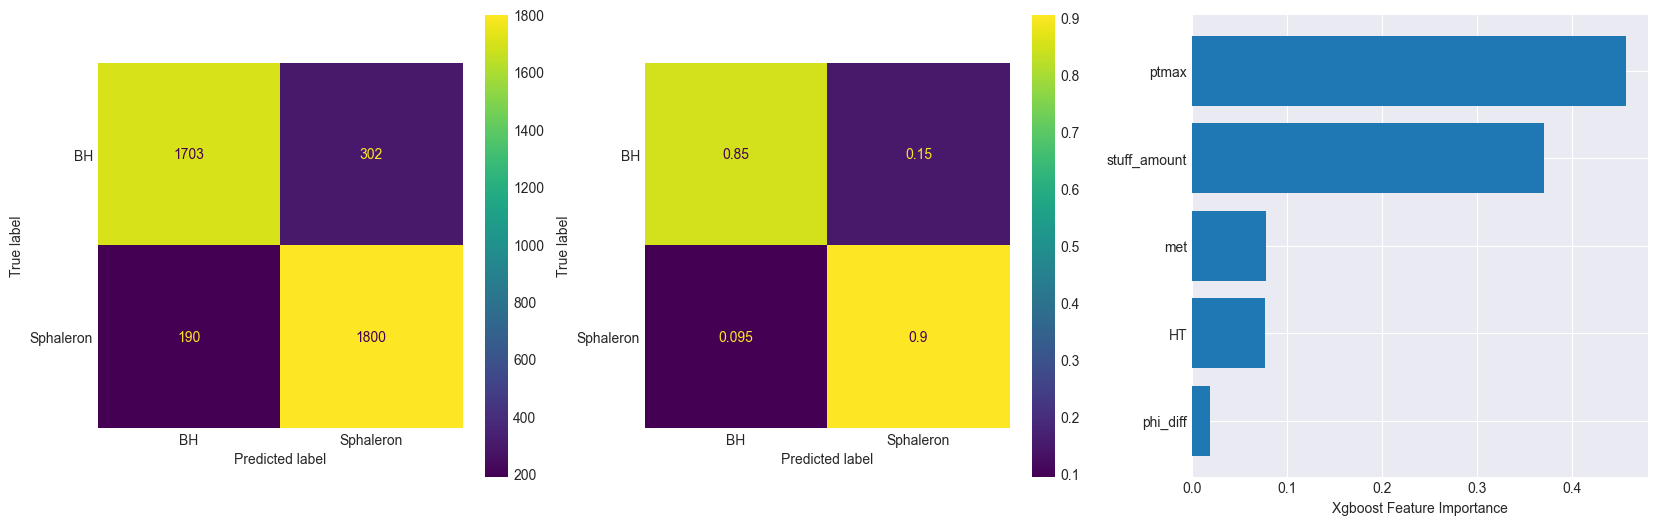

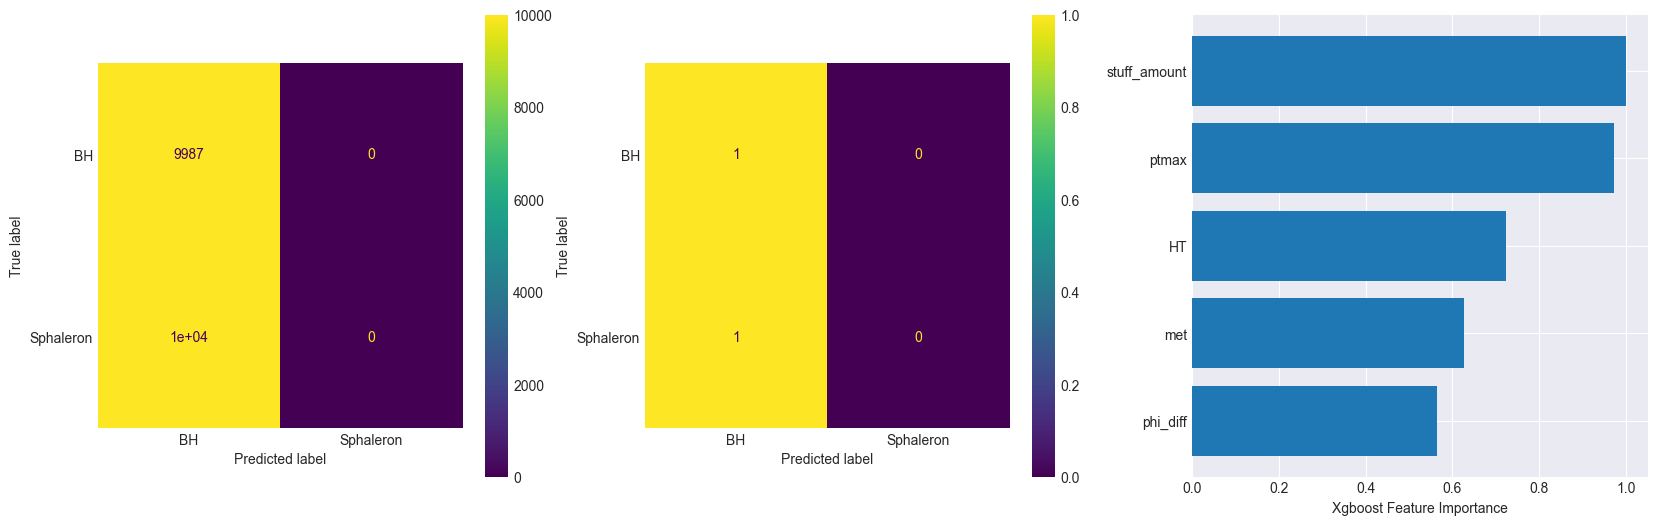

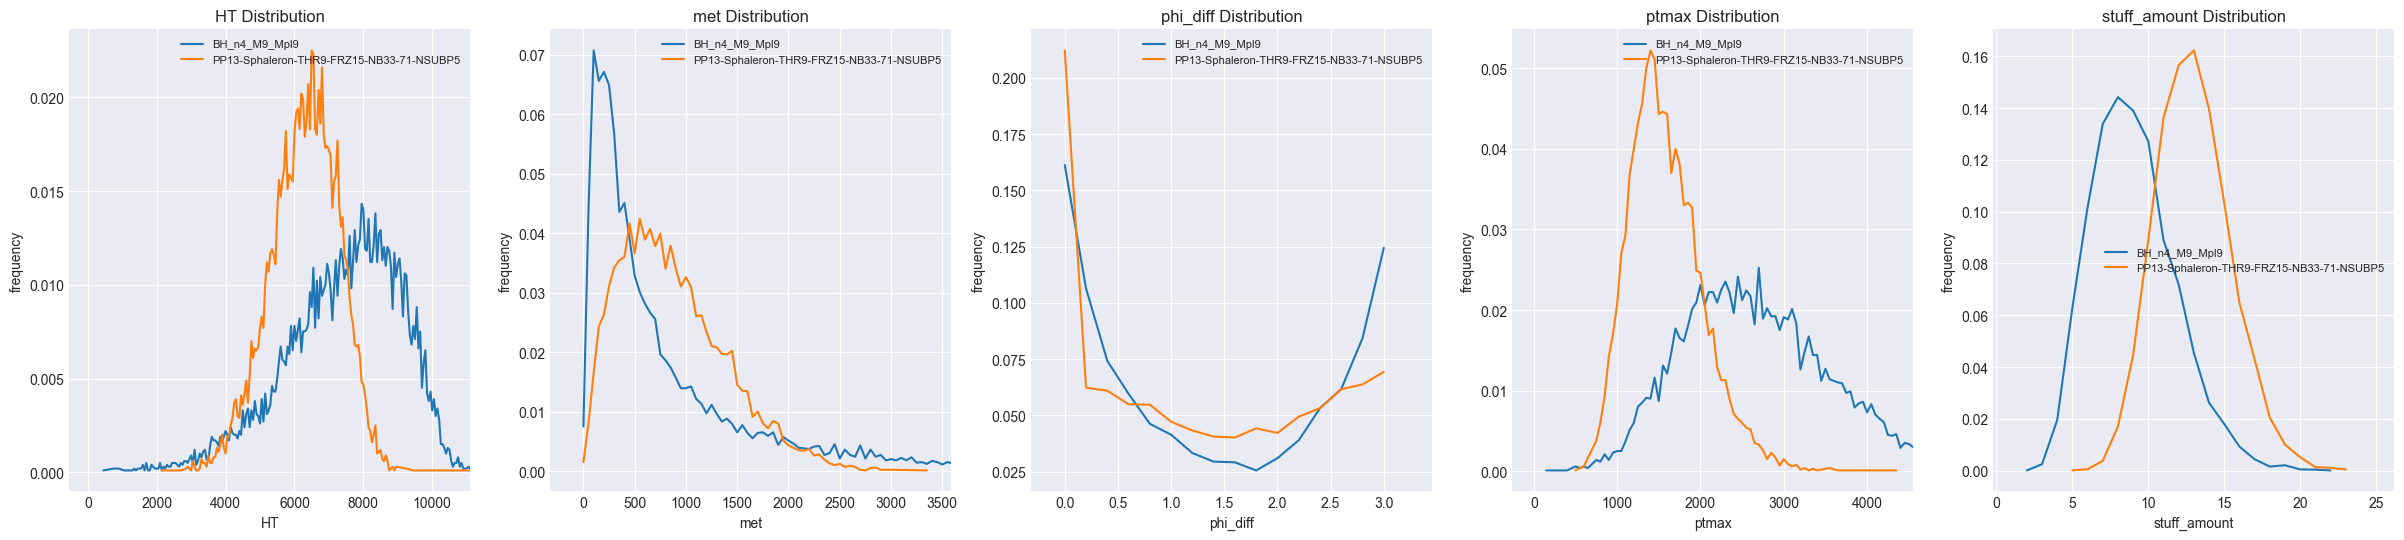

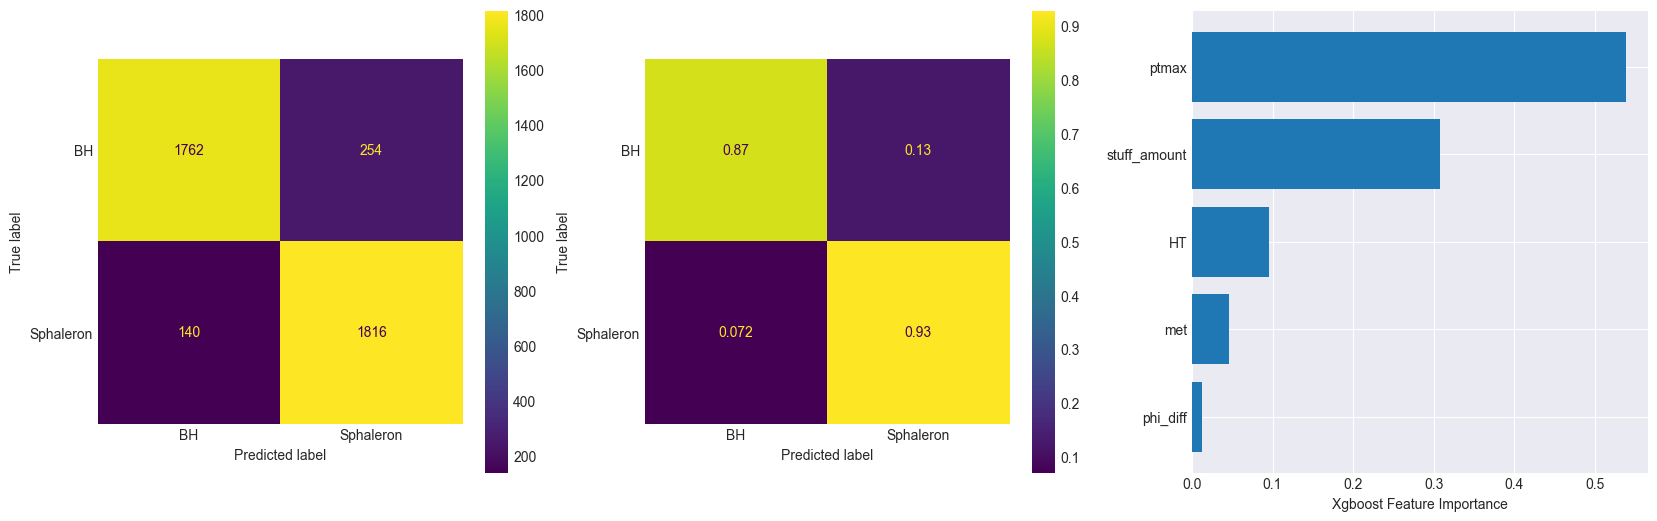

In [147]:
from Plotter import plotter

for sphal_file in sphal_files:
    for bh_file in bh_files:
        model_dataframes_input = selector(bh_file, sphal_file, model_dataframes)
        model(model_dataframes_input, data_variables, folders)


        eff_tups, data_variables = eff_tup_retriever(False, folders, tree_dataframes, bh_file, sphal_file)
        evaluations = EventEvaluator(model_dataframes_input, eff_tups, data_variables)
        evaluations_plot(evaluations, eff_tups)


        plotter(data_variables, model_dataframes_input, [bh_file, sphal_file], filter_strengths = [0.99, 0.99, 1, 0.975, 1], binsizes = [50, 50, 0.2, 50, 0.5])
        